In [1]:
from collections import defaultdict
from datetime import date
import copy
import os
from tqdm import tqdm

import yaml
import json

import numpy as np
import pandas as pd
import pandas_datareader as pdr

from PIL import Image

import quandl
import yfinance as yf

import plotly
import plotly.express as px
import plotly.graph_objects as go

from dotenv import load_dotenv

# create a .env file with QUANDL_TOKEN=xxxxxx
load_dotenv()
quandl_token = os.getenv('QUANDL_TOKEN')

print(f"numpy                {np.__version__:<20}")
print(f"pandas               {pd.__version__:<20}")
print(f"pandas_datareader    {pdr.__version__:<20}")
print(f"yfinance             {yf.__version__:<20}")
print(f"plotly               {plotly.__version__:<20}")


OUTPUT_PNG=True


numpy                1.24.2              
pandas               1.5.3               
pandas_datareader    0.10.0              
yfinance             0.2.12              
plotly               5.13.0              


### Awesome dataviz


- [BD Econ chartbook](https://github.com/bdecon/US-chartbook) [PDF](https://www.bd-econ.com/chartbook.pdf) (amazing 😎)

- [Visual Capitalist](https://www.visualcapitalist.com/)

### Official data
- [FRED](https://fred.stlouisfed.org/)
- [FRB](https://www.federalreserve.gov/data.htm)
- [OECD](https://data.oecd.org/) [Alt](https://www.oecd-ilibrary.org/statistics)
- [US Treasury](https://home.treasury.gov/)
- [BEA](https://www.bea.gov/data/economic-accounts/international)
- [US Government Open Data](https://data.gov/)
- [Conference Board](https://www.conference-board.org/data/)
- [Eurostat](https://ec.europa.eu/eurostat/data/database) [blog post](https://towardsdatascience.com/using-eurostat-statistical-data-on-europe-with-python-2d77c9b7b02b) 
- [ECB](https://sdw.ecb.europa.eu/)
- [World Bank](https://data.worldbank.org/) [blog post](https://blogs.worldbank.org/opendata/introducing-wbgapi-new-python-package-accessing-world-bank-data) [Alt](https://databank.worldbank.org/source/world-development-indicators)
- [IMF](https://data.imf.org/?sk=388dfa60-1d26-4ade-b505-a05a558d9a42) 
https://www.imf.org/external/datamapper/NGDP_RPCH@WEO/OEMDC/ADVEC/WEOWORLD
- [UN](http://data.un.org/Default.aspx) [Alt](https://unctadstat.unctad.org/EN/)
- [BIS](https://www.bis.org/statistics/index.htm?m=6%7C37)
- [ADB](https://data.adb.org/)
- [IDB](https://data.iadb.org/DataCatalog/Dataset)
- [WHO](https://apps.who.int/gho/data/node.home)

### Other data

- [Economy.com](https://www.economy.com/Freelunch/)
- [Trading Economics](https://tradingeconomics.com/)
- [NationMaster](https://www.nationmaster.com/)
- [Knoema](https://knoema.com/atlas)
- [IndexMundi](https://www.indexmundi.com/)


### Econ calendars

- [NY Fed](https://www.newyorkfed.org/research/calendars/nationalecon_cal.html)
- [FRED](https://fred.stlouisfed.org/releases/calendar)
- [MarketWatch](https://www.marketwatch.com/economy-politics/calendar)

### Free datasets

- https://datahub.io/collections/economic-data
- https://www.kaggle.com/datasets
- https://github.com/awesomedata/awesome-public-datasets
- https://datasetsearch.research.google.com/
- https://archive.ics.uci.edu/ml/index.php
- https://registry.opendata.aws/
- https://msropendata.com/


In [2]:
# TODO:

# color template
# import plotly.io as pio

# # naming a layout theme for future reference
# pio.templates["google"] = go.layout.Template(
#     layout_colorway=['#4285F4', '#DB4437', '#F4B400', '#0F9D58',
#                      '#185ABC', '#B31412', '#EA8600', '#137333',
#                      '#d2e3fc', '#ceead6']
# )

# # setting Google color palette as default
# pio.templates.default = "google"

# would be nice to write a generic pandas shift by 1 year based on frequency of the dataframe
# get all data incl future from fred
# yield curve chart, other custom charts
# recession shading

# break down retail sales, consumption, employment, price with bar charts or composition flow over time
# change in composition of labor force , status over time

# jolts hires/fires/quits/openings

# hours worked that tracks with gdp

# stock valuations, fed model, shiller model, dividend yield, pe yield, 
# real yields

# dot plot median forecast going out 3 years
# Yield curve
# contributions to GDP
# contributions to inflation
#     #               A466RD3Q052SBEA
# #                 Profit per unit of real gross value added of nonfinancial corporate business: Corporate profits after tax with IVA and CCAdj (unit profits from current production) (A466RD3Q052SBEA)	
# high frequency stuff
#     'DCOILWTICO': {'source': 'FRED', 'freq': 'D'}, 
#     'DEXUSEU': {'source': 'FRED', 'freq': 'D'},
#     'GVZCLS': {'source': 'FRED', 'freq': 'D'}, 
#     'VIXCLS': {'source': 'FRED', 'freq': 'D'}, 
#     'DIVIDEND': {'source': 'FRED', 'freq': 'Q'},
#     'BCHAIN/MKPRU': {'source': 'QUANDL', 'freq': 'D'},
#     'USTREASURY/YIELD': {'source': 'QUANDL', 'freq': 'D'}, 
#     'USTREASURY/REALYIELD': {'source': 'QUANDL', 'freq': 'D'},
#     'MULTPL/SHILLER_PE_RATIO_MONTH': {'source': 'QUANDL', 'freq': 'M'}, 
#     'LBMA/GOLD': {'source': 'QUANDL', 'freq': 'D'},
#     '^SPX': {'source': 'STOOQ', 'freq': 'D'}, 
#     '^DJI': {'source': 'STOOQ', 'freq': 'D'}
# }
#     # balance sheets, debt household wealth

# override download dates, run future dates for e.g. dotplot

# add option to save figure as HTML
# python save pickle at the end
# make a github.io chartbook page
# run a process on hetzner
# - git clone druce.github.io
# - run update with all the figures
# - git push "figures date"

# currently yaml just defines downloads
# could define a whole chartbook
# add section. order for each chart
# for each section, for each chart in order, run transform and default chart on each one in order
# pickle a set of plotly options to define a default chart
# for a complex chart, define a custom transform of multiple series, different set of plotly options and df input schmea


In [3]:
curdate = date.today()
start = date(year=curdate.year-10, month=curdate.month, day=curdate.day)
# go far out to capture economic projectsions, future not read by default
end = date(year=curdate.year+10, month=curdate.month, day=curdate.day)
macro_indicators = dict()
start

datetime.date(2013, 7, 26)

In [4]:
# load indicators from YAML file
with open("indicators.yaml", "r") as stream:
    try:
        INDICATORS=yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        

In [5]:
FRED_INDICATORS = INDICATORS['FRED'].keys()
QUANDL_INDICATORS = INDICATORS['QUANDL'].keys() 
STOOQ_INDICATORS = INDICATORS['STOOQ'].keys()


In [6]:
# download from quandl
tq_quandl = tqdm(QUANDL_INDICATORS)
tq_quandl.set_description("Downloading data from QUANDL")
for indicator in tq_quandl:
    # modify all indicator names '/': like "USTREASURY/YIELD" to "USTREASURY_YIELD"
    macro_indicators[indicator.replace("/", "_")] = quandl.get(indicator, start_date=start, end_date=end, 
                                                               authtoken=quandl_token)

for indicator in list(INDICATORS['QUANDL'].keys()):
    INDICATORS['QUANDL'][indicator.replace("/", "_")] = INDICATORS['QUANDL'].pop(indicator)

QUANDL_INDICATORS = [indicator.replace("/", "_") for indicator in QUANDL_INDICATORS]

macro_indicators['USTREASURY_YIELD'].head(5)


1 MO  2 MO  3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  \
Date                                                                      
2013-07-26  0.02   NaN  0.03  0.07  0.11  0.31  0.59  1.36  1.98   2.58   
2013-07-29  0.01   NaN  0.03  0.07  0.11  0.33  0.61  1.37  2.00   2.61   
2013-07-30  0.03   NaN  0.04  0.07  0.11  0.33  0.62  1.39  2.02   2.63   
2013-07-31  0.03   NaN  0.04  0.08  0.11  0.31  0.61  1.38  2.00   2.60   
2013-08-01  0.02   NaN  0.04  0.08  0.13  0.35  0.65  1.49  2.15   2.74   

            20 YR  30 YR  
Date                      
2013-07-26   3.31   3.61  
2013-07-29   3.35   3.66  
2013-07-30   3.36   3.67  
2013-07-31   3.34   3.64  
2013-08-01   3.48   3.77

In [7]:
macro_indicators['MULTPL_SHILLER_PE_RATIO_MONTH'].sort_index()[-10:]

Value
Date             
2023-02-01  28.98
2023-02-28  28.84
2023-03-01  28.05
2023-03-31  29.35
2023-04-01  28.94
2023-05-01  28.99
2023-05-31  29.30
2023-06-01  30.33
2023-06-30  31.07
2023-07-01  31.04

In [8]:
# download from FRED
tq_fred = tqdm(FRED_INDICATORS)
tq_fred.set_description('Downloading data from FRED')

for indicator in tq_fred:
    macro_indicators[indicator] = pdr.fred.FredReader(indicator, start=start, end=end, timeout=90).read()

macro_indicators['GDP'].head(4)


GDP
DATE                 
2013-10-01  17133.114
2014-01-01  17144.281
2014-04-01  17462.703
2014-07-01  17743.227

In [9]:
# download from stooq
for indicator in tqdm(STOOQ_INDICATORS):
    macro_indicators[indicator.replace("^", "")]= pdr.get_data_stooq(indicator, start, end)
    
macro_indicators['SPX'].head(5)


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Open     High      Low    Close        Volume
Date                                                        
2023-07-25  4555.19  4580.62  4552.42  4567.46  2.305629e+09
2023-07-24  4543.39  4563.41  4541.29  4554.64  2.156130e+09
2023-07-21  4550.16  4555.00  4535.79  4536.34  3.277670e+09
2023-07-20  4554.38  4564.74  4527.56  4534.87  2.595427e+09
2023-07-19  4563.87  4578.43  4557.48  4565.72  2.597462e+09

In [10]:
# merge keys to have dict of all regardless of source
ALL_INDICATORS =  {**INDICATORS['FRED'], **INDICATORS['QUANDL'],  **INDICATORS['STOOQ']}

In [11]:
generic_layout = dict(
    autosize=True,
            # width=640,
            # height=480,            
            margin={'l': 10, 'r': 15, 't': 40},
            paper_bgcolor="white",
            #plot_bgcolor="white",
            showlegend=False,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="left",
                x=0
            ),
            xaxis={
                'ticks': 'inside',
                'showgrid': True,            # thin lines in the background
                'zeroline': False,           # thick line at x=0
                'visible': True,             # numbers below
                'showline': True,            # Show X-Axis
                'linecolor': 'black',        # Color of X-axis
                'tickfont_color': 'black',   # Color of ticks
                'showticklabels': True,      # Show X labels
                'mirror': True,              # draw right axis
            },
            yaxis={
                'ticks': 'inside',
                'showgrid': True,            # thin lines in the background
                'zeroline': False,           # thick line at x=0
                'visible': True,             # numbers below
                'showline': True,            # Show X-Axis
                'linecolor': 'black',        # Color of X-axis
                'tickfont_color': 'black',   # Color of ticks
                'showticklabels': True,      # Show X labels
                'side': 'left',
                'mirror': True,
            },
        )

with open('generic.json', 'w') as outfile:
    outfile.write(json.dumps(generic_layout, indent=4))
    

In [12]:
periods = {
    'Q': 4,
    'M': 12,
    'W': 52,
}

yaxis_titles = {
    'YOY': "YoY %Ch",
    'NONE': "Level",
}
    

In [13]:
# True to make PNGs, False for interactive JS
def chart_generic(df=None,
                  col=None,
                  title=None,
                  xaxis_title=None,
                  yaxis_title=None,
                  recessions=False,
                  output_png=OUTPUT_PNG,
                  **kwargs
                 ):

    fig = go.Figure(
        data=[go.Scatter(y=df[col],
                         x=df.index.to_list(),
                         line_width=2,
                         # color_discrete_sequence=plotly.colors.qualitative.Dark24
                        ),
             ],
        layout=generic_layout)
    
    fig.update_layout(dict(title=title,
                           xaxis_title=xaxis_title,
                           yaxis_title=yaxis_title,
                          ))
    if OUTPUT_PNG:
        fig.write_image("images/%s.png" % col)
        return Image.open("images/%s.png" % col)        
    else:
        return fig
    

In [14]:
def do_transform(**kwargs):
    """given a dataframe, apply transforms like yoy"""    
    df = kwargs['df']
    indicator = kwargs.setdefault('indicator', "")
    transform = kwargs.setdefault('transform', 'NONE')
    freq = kwargs.setdefault('freq', 'M')
       
    col = "%s_%s_%s" % (indicator, freq, transform)
    df = df.set_index(df.index.astype("period[%s]" % freq).to_timestamp(freq=freq))
    if transform == 'NONE':
        df[col] = df[df.columns[0]]
        
    if transform == 'YOY':
        if freq=='D':
            # offset 1 year, prev business day if not business day
            df['date_1y'] = df.index - pd.offsets.DateOffset(years=1) + pd.offsets.Day() - pd.offsets.BDay()
            # get previous val
            prev_if_exists = lambda x: df.loc[x.date_1y][indicator] if x.date_1y in df.index else np.nan
            df['prev_1y'] = df.apply(prev_if_exists, axis='columns')
            # any NAs, get previous row
            df['prev_1y'] = df['prev_1y'].ffill(axis = 0)
            df[col] = df[indicator] / df['prev_1y'] * 100 - 100
        else:
            df[col] = df[indicator].pct_change(periods=periods[freq], freq=freq) * 100
    df = df.dropna()
    
    retdict = kwargs
    retdict['col']=col
    retdict['yaxis_title'] = yaxis_titles[transform]
    retdict['df'] = df
    
    return retdict



In [15]:
def chartbook_panel(indicator):
    indicator_params = ALL_INDICATORS[indicator]
    indicator_params['indicator'] = indicator
    indicator_params['df'] = macro_indicators[indicator]
    chart_params = do_transform(**indicator_params)
    return chart_generic(**chart_params)


# GDP

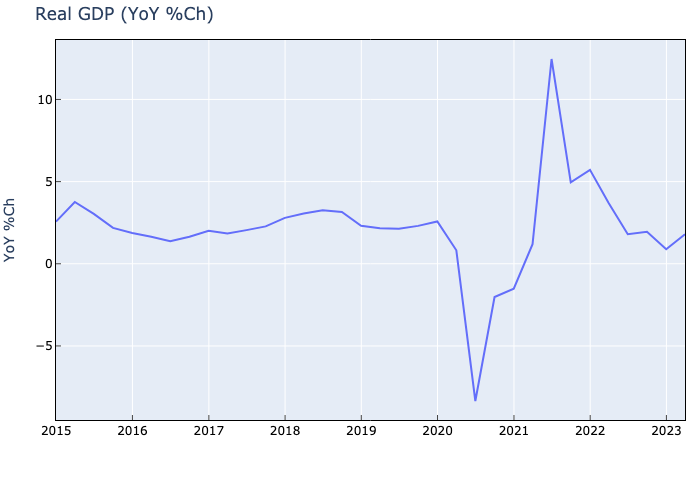

In [16]:
chartbook_panel('GDPC1')


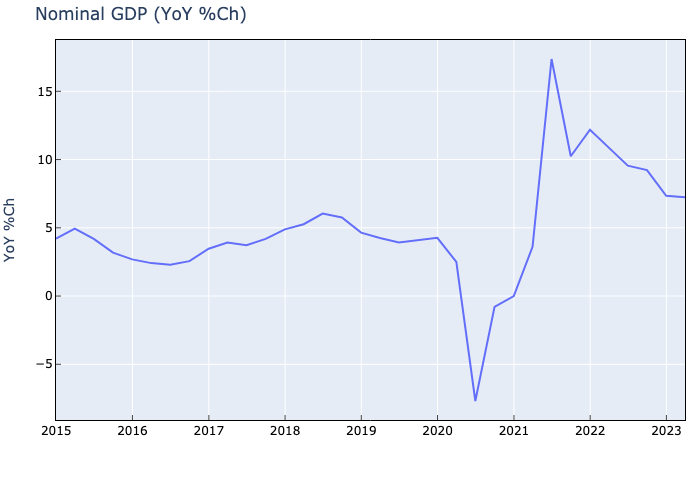

In [17]:
chartbook_panel('GDP')


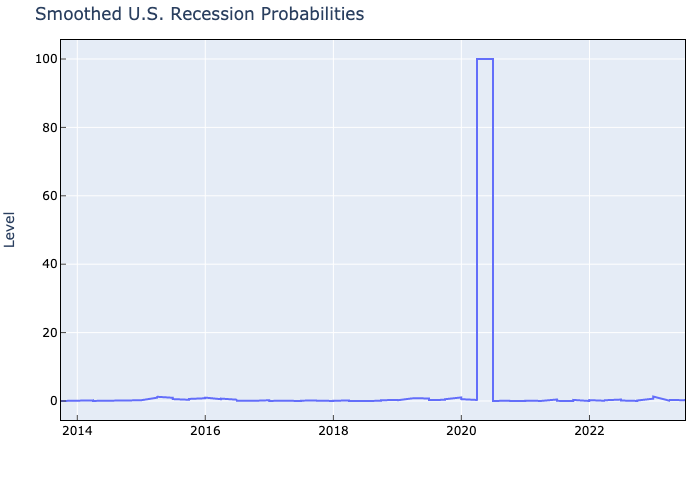

In [18]:
chartbook_panel('RECPROUSM156N')


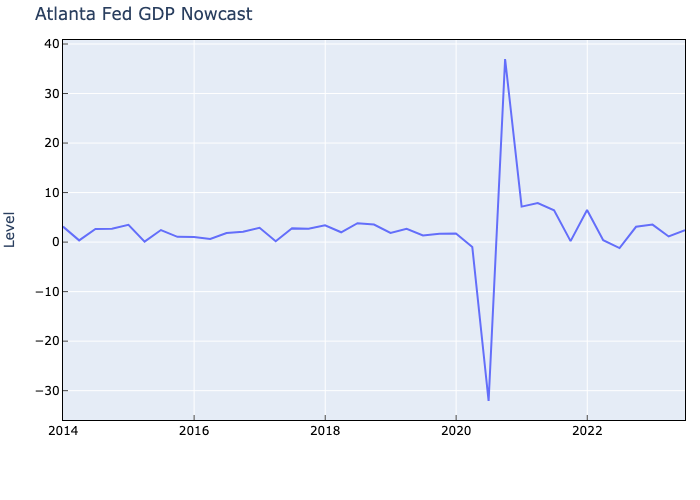

In [19]:
chartbook_panel('GDPNOW')

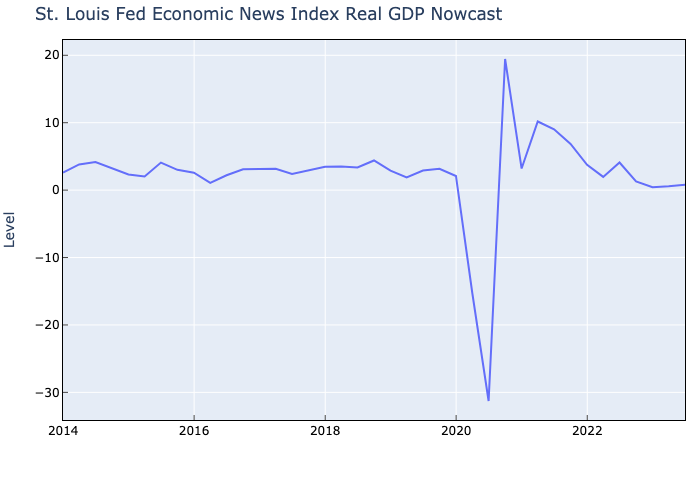

In [20]:
chartbook_panel('STLENI')

# Prices

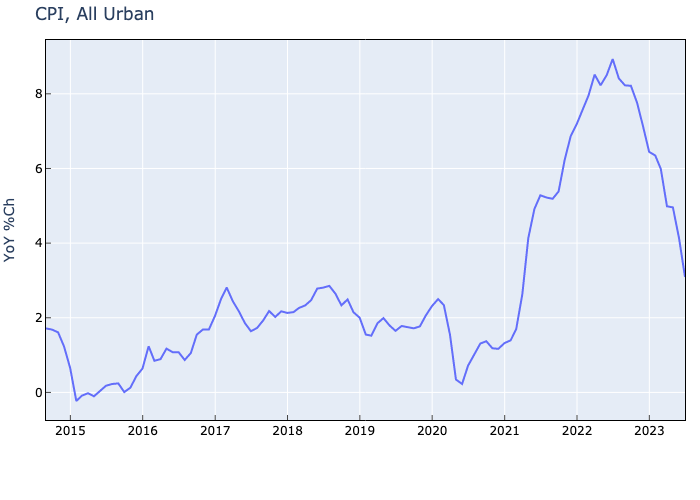

In [21]:
chartbook_panel('CPIAUCSL')


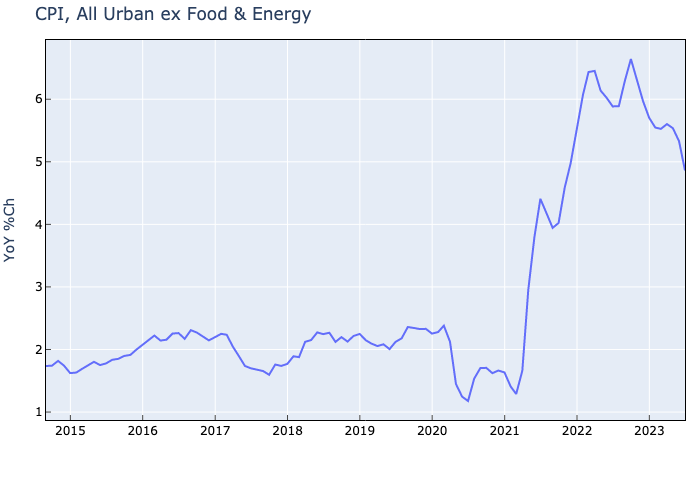

In [22]:
chartbook_panel('CPILFESL')


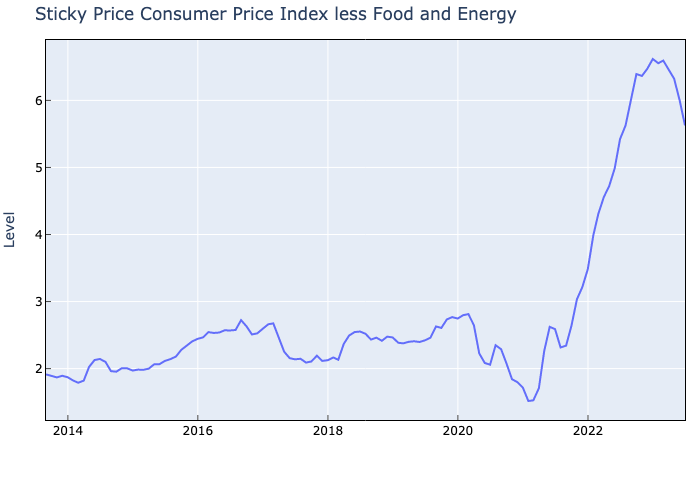

In [23]:
chartbook_panel('CORESTICKM159SFRBATL')


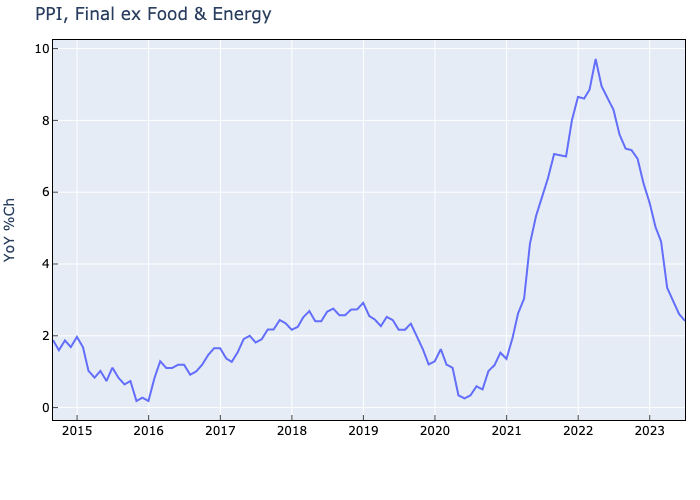

In [24]:
chartbook_panel('PPICOR')


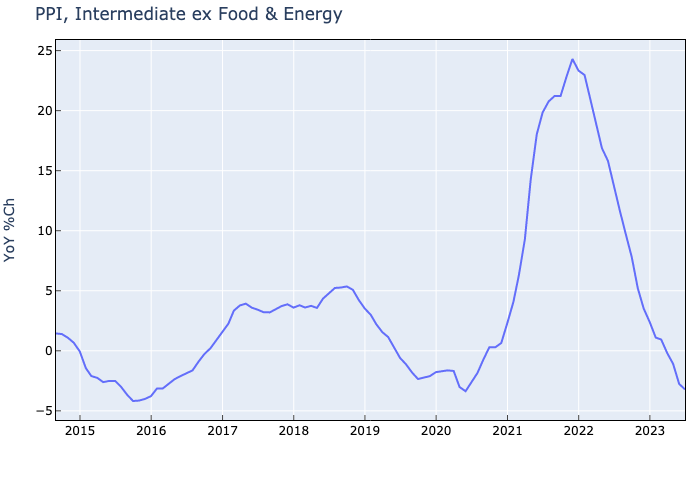

In [25]:
chartbook_panel('WPUID69115')


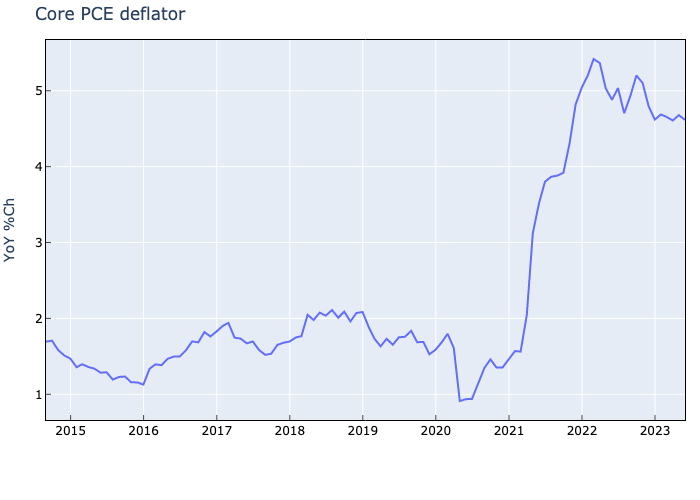

In [26]:
chartbook_panel('PCEPILFE')


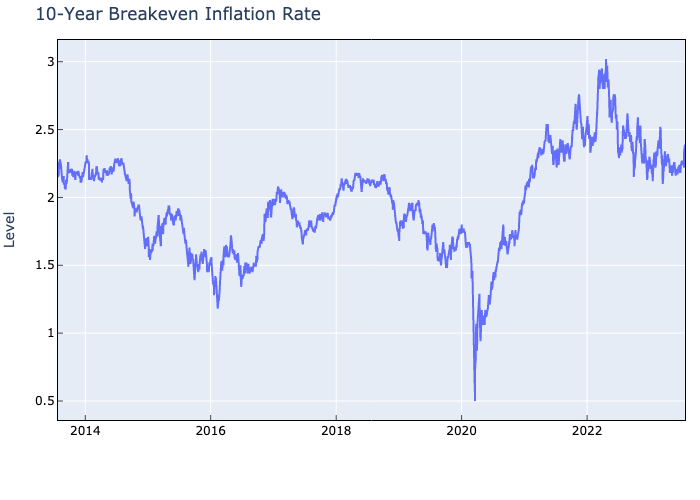

In [27]:
chartbook_panel('T10YIE')


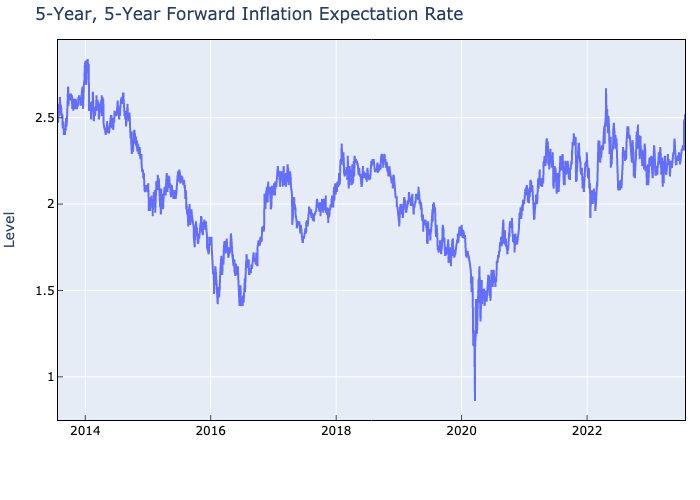

In [28]:
chartbook_panel('T5YIFR')


# Monetary Policy and Rates

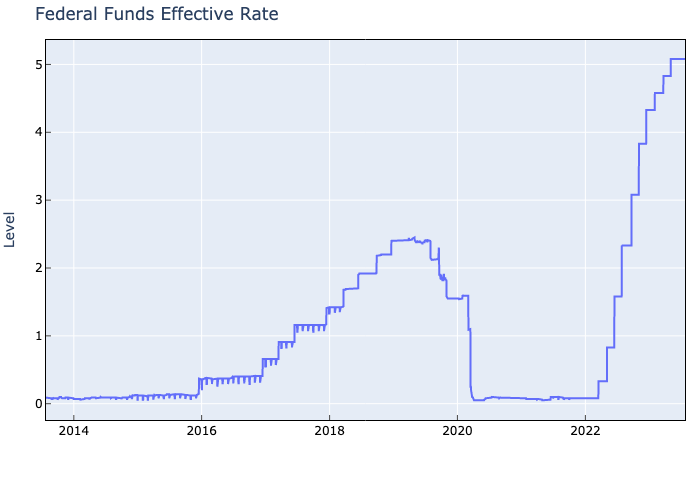

In [29]:
chartbook_panel('DFF')


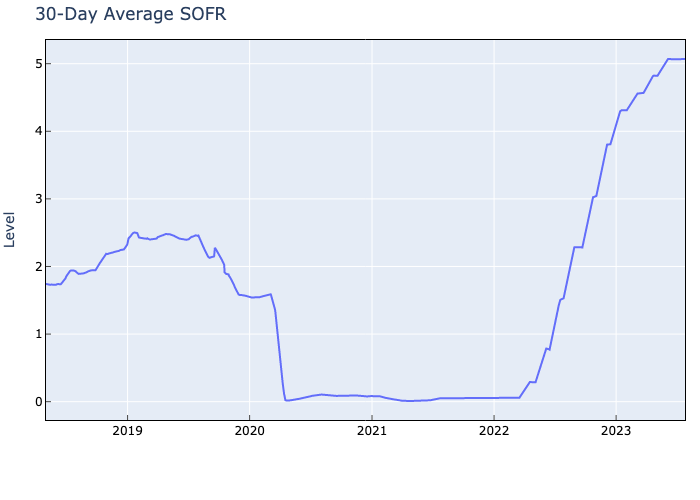

In [30]:
chartbook_panel('SOFR30DAYAVG')


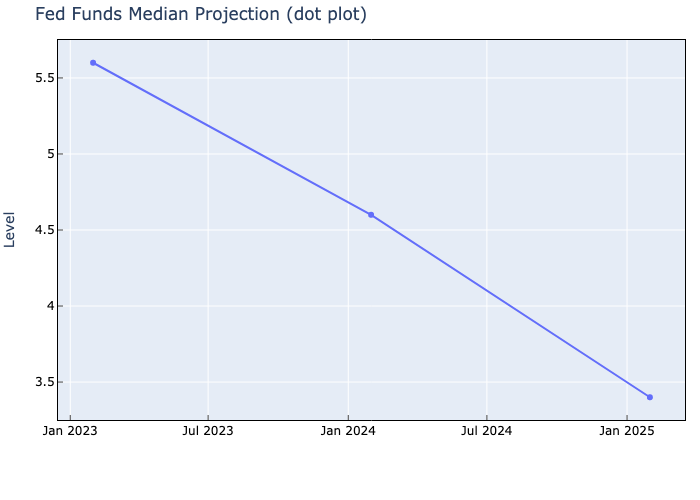

In [31]:
chartbook_panel('FEDTARMD')


In [32]:
# Fed Funds Median Projection (dot plot) None Level

# needs special handling, chart through 2025
# indicator = 'FEDTARMD'

# indicator_params = INDICATORS[indicator]
# indicator_params['df'] = macro_indicators[indicator]

# chart_params = do_transform(**indicator_params)
# yoy_m(**chart_params)


In [33]:
ychistory = macro_indicators['USTREASURY_YIELD']
ycdf_last = ychistory.index[-1]

ycdf_1y = ycdf_last - pd.offsets.DateOffset(years=1) + pd.offsets.Day() - pd.offsets.BDay()
if not ycdf_1y in ychistory.index:
    ycdf_1y += pd.offsets.BDay()
    
ycdf_3m = ycdf_last - pd.offsets.DateOffset(months=3) + pd.offsets.Day() - pd.offsets.BDay()
if not ycdf_3m in ychistory.index:
    ycdf_3m += pd.offsets.BDay()

ycdf_1m = ycdf_last - pd.offsets.DateOffset(months=1) + pd.offsets.Day() - pd.offsets.BDay()
if not ycdf_1m in ychistory.index:
    ycdf_1m += pd.offsets.BDay()
    
ycdf_1w = ycdf_last - pd.offsets.DateOffset(weeks=1) + pd.offsets.Day() - pd.offsets.BDay()
if not ycdf_1w in ychistory.index:
    ycdf_1w += pd.offsets.BDay()

ycdf = ychistory.loc[ychistory.index==ycdf_last] \
    .transpose()
ycdf.columns = ['YIELDCURVE']

tempdf = ychistory.loc[ychistory.index==ycdf_1y] \
    .transpose()
tempdf.columns = ['1Y']
ycdf['1Y'] = tempdf['1Y'].tolist()

tempdf = ychistory.loc[ychistory.index==ycdf_3m] \
    .transpose()
tempdf.columns = ['3M']
ycdf['3M'] = tempdf['3M'].tolist()

tempdf = ychistory.loc[ychistory.index==ycdf_1m] \
    .transpose()
tempdf.columns = ['1M']
ycdf['1M'] = tempdf['1M'].tolist()

tempdf = ychistory.loc[ychistory.index==ycdf_1w] \
    .transpose()
tempdf.columns = ['1W']
ycdf['1W'] = tempdf['1W'].tolist()

ycdf['X'] = [1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
ycdf=ycdf.set_index('X')

ycdf

col = 'YIELDCURVE'
title = 'Yield Curve'
xaxis_title = 'Term'
yaxis_title = 'Yield'
fig = go.Figure(
    data=[go.Scatter(y=ycdf[col],
                     x=ycdf.index.to_list(),
                     name="latest",
                     line_width=2,
                     # color_discrete_sequence=plotly.colors.qualitative.Dark24
                    ),
#           go.Scatter(y=ycdf['3M'],
#                      x=ycdf.index.to_list(),
#                      name="3 months ago",
#                      line_width=2,
#                      # color_discrete_sequence=plotly.colors.qualitative.Dark24
#                     ),
#           go.Scatter(y=ycdf['1M'],
#                      x=ycdf.index.to_list(),
#                      name="1 month ago",
#                      line_width=2,
#                      # color_discrete_sequence=plotly.colors.qualitative.Dark24
#                     ),
          go.Scatter(y=ycdf['1W'],
                     x=ycdf.index.to_list(),
                     name="1 week ago",
                     line_width=2,
                     # color_discrete_sequence=plotly.colors.qualitative.Dark24
                    ),
          go.Scatter(y=ycdf['1Y'],
                     x=ycdf.index.to_list(),
                     name="1 year ago",
                     line_width=2,
                     # color_discrete_sequence=plotly.colors.qualitative.Dark24
                    ),          
         ],
    layout=generic_layout)

fig.update_layout(dict(title=title,
                       xaxis_title=xaxis_title,
                       yaxis_title=yaxis_title,
                      ))

fig

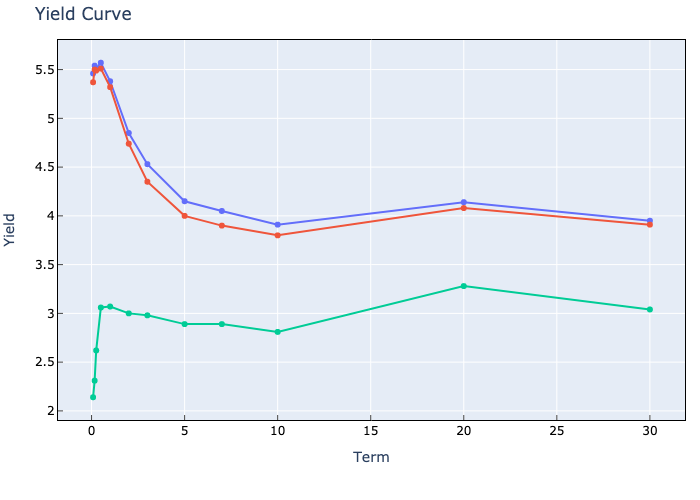

In [34]:
fig.write_image("images/%s.png" % col)
Image.open("images/%s.png" % col)        


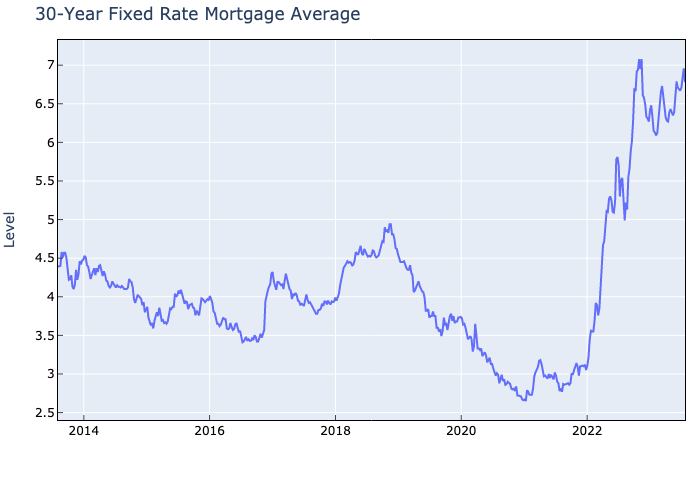

In [35]:
chartbook_panel('MORTGAGE30US')


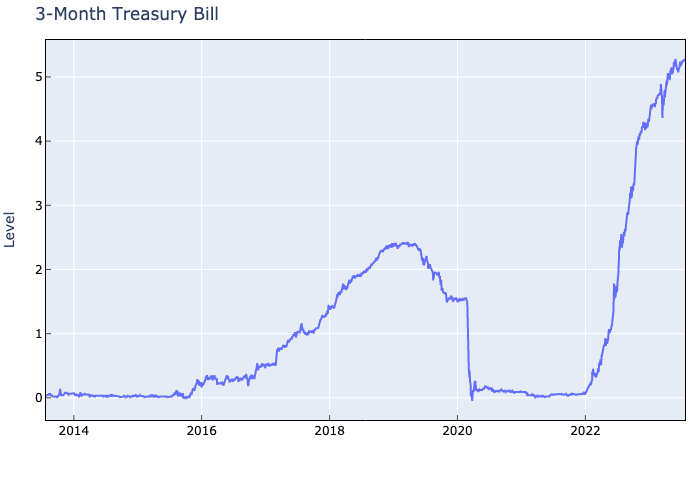

In [36]:
chartbook_panel('DTB3')


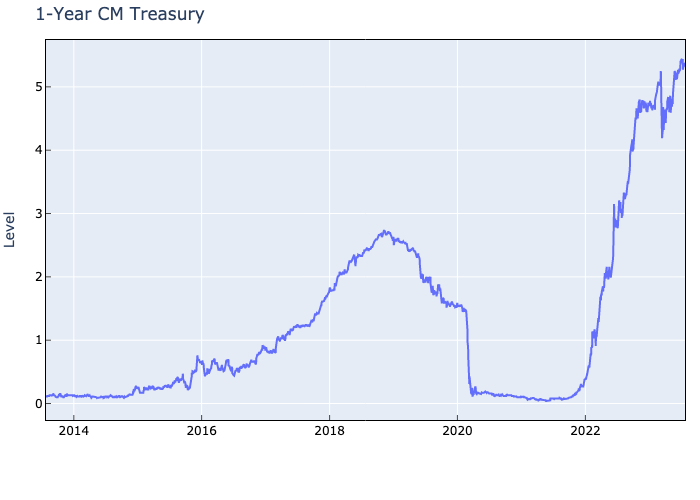

In [37]:
chartbook_panel('DGS1')


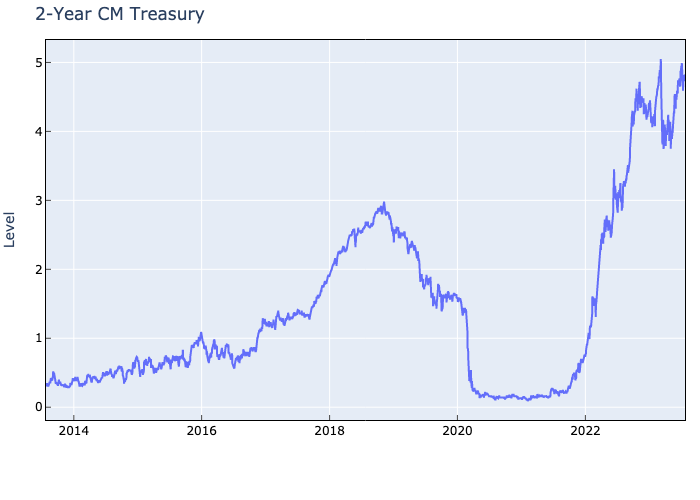

In [38]:
chartbook_panel('DGS2')


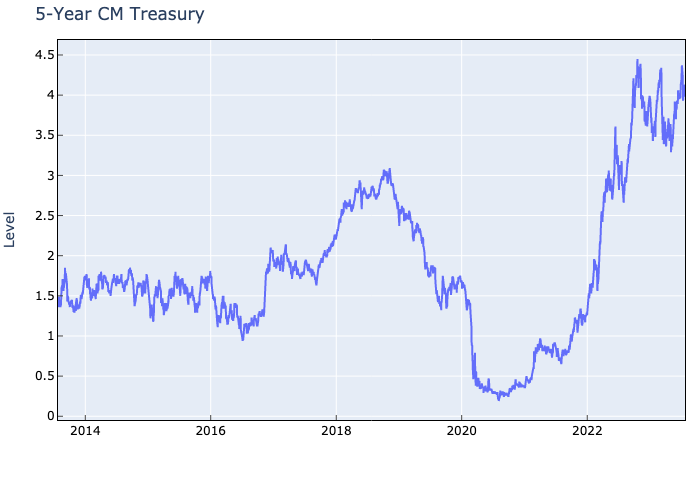

In [39]:
chartbook_panel('DGS5')


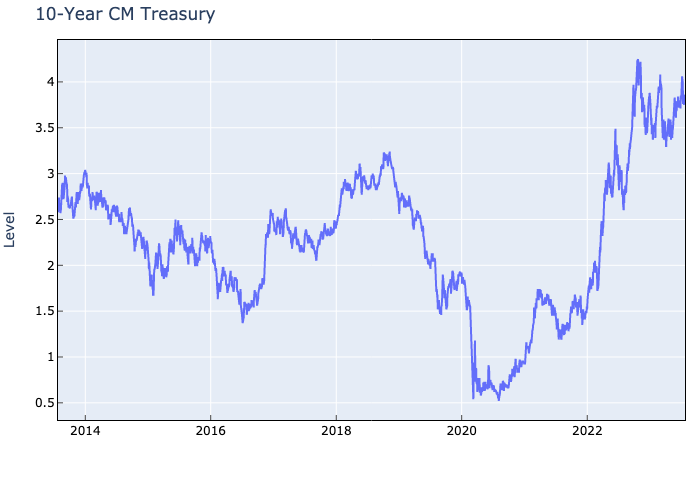

In [40]:
chartbook_panel('DGS10')


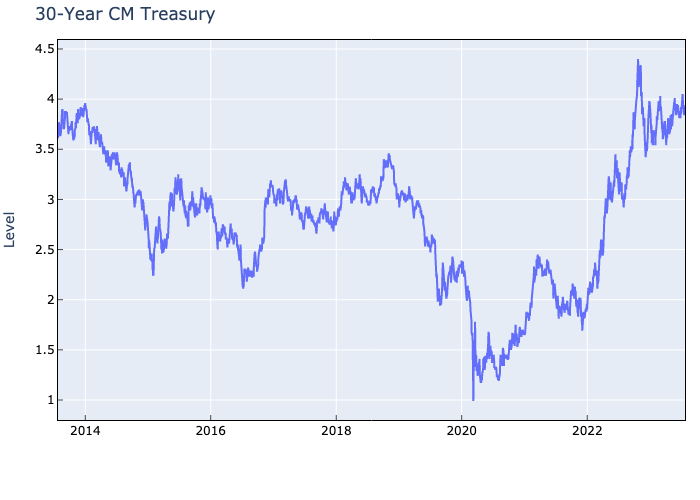

In [41]:
chartbook_panel('DGS30')


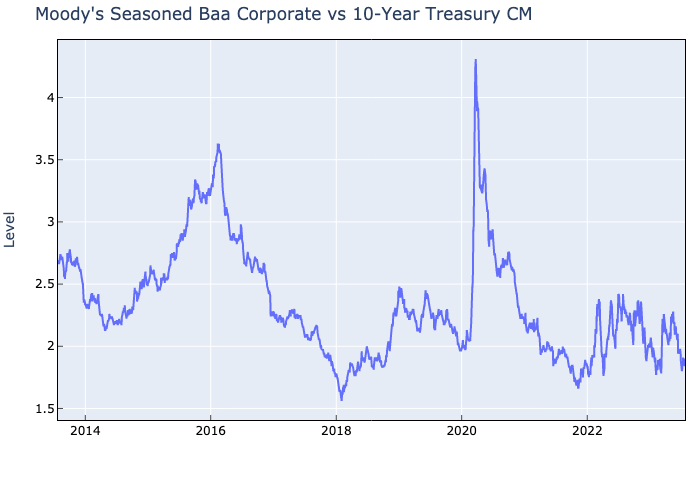

In [42]:
chartbook_panel('BAA10Y')


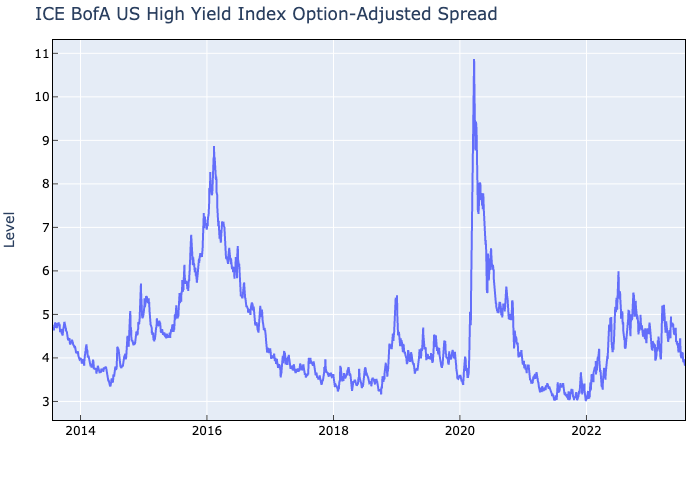

In [43]:
chartbook_panel('BAMLH0A0HYM2')


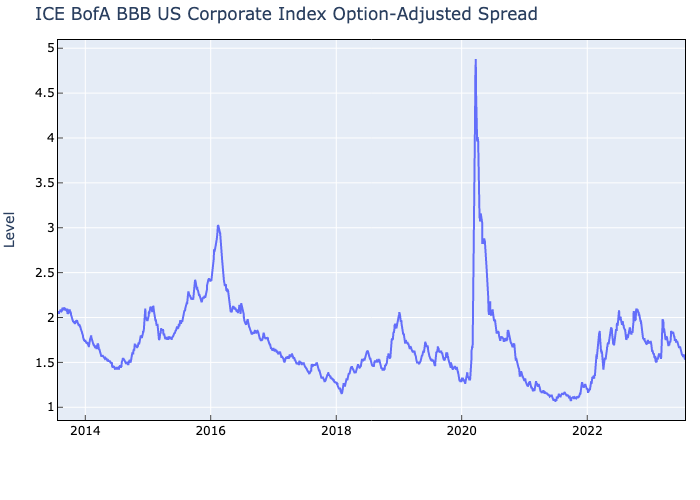

In [44]:
chartbook_panel('BAMLC0A4CBBB')


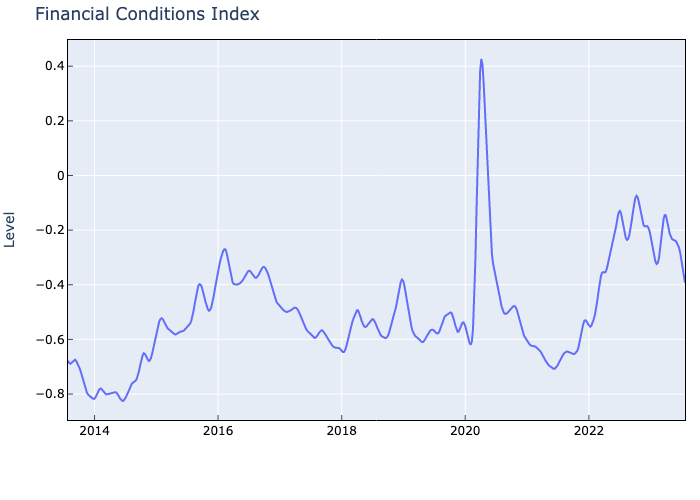

In [45]:
chartbook_panel('NFCI')


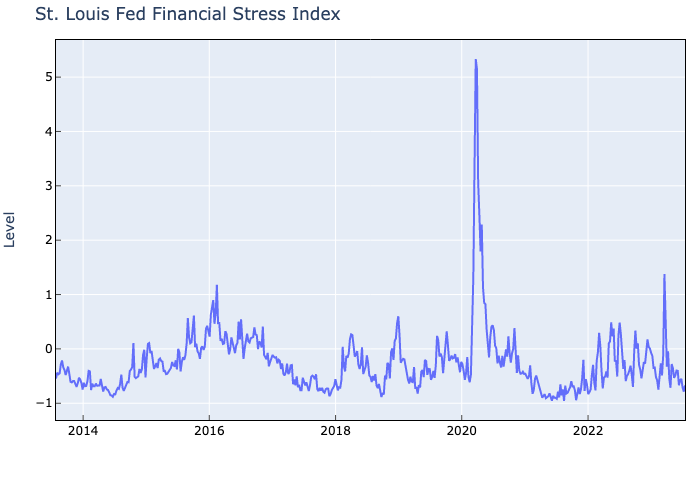

In [46]:
chartbook_panel('STLFSI4')


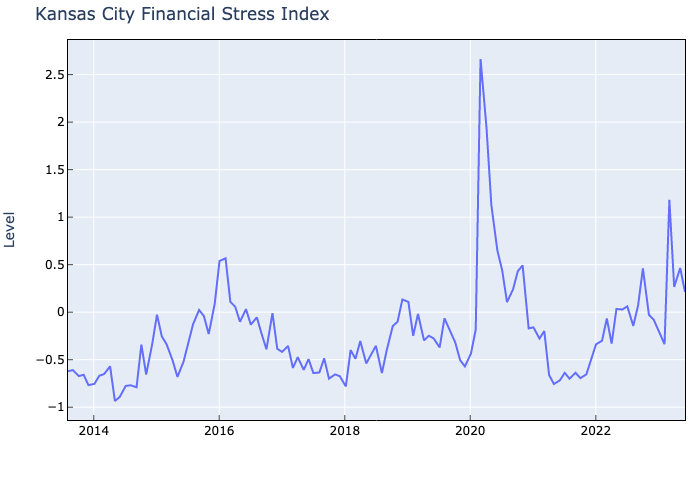

In [47]:
chartbook_panel('KCFSI')


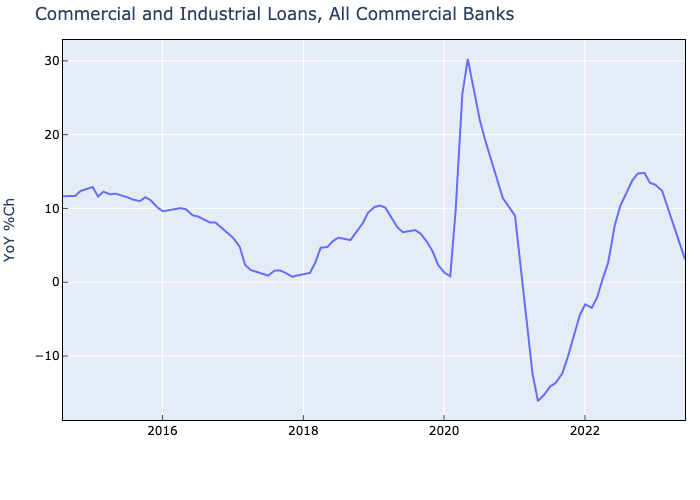

In [48]:
chartbook_panel('BUSLOANS')


# Labor Markets


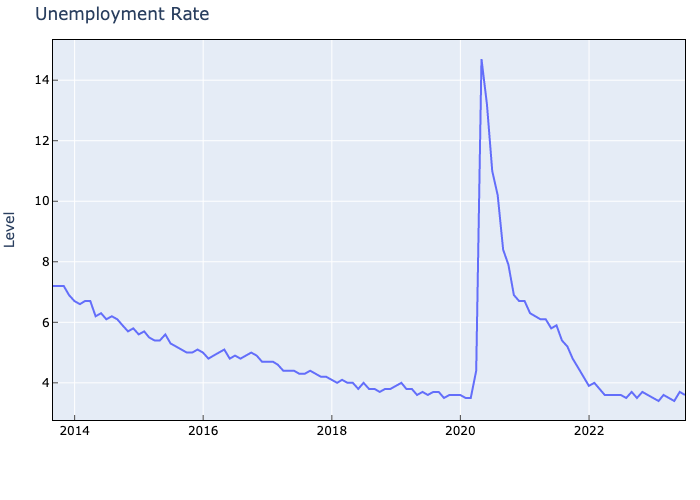

In [49]:
chartbook_panel('UNRATE')


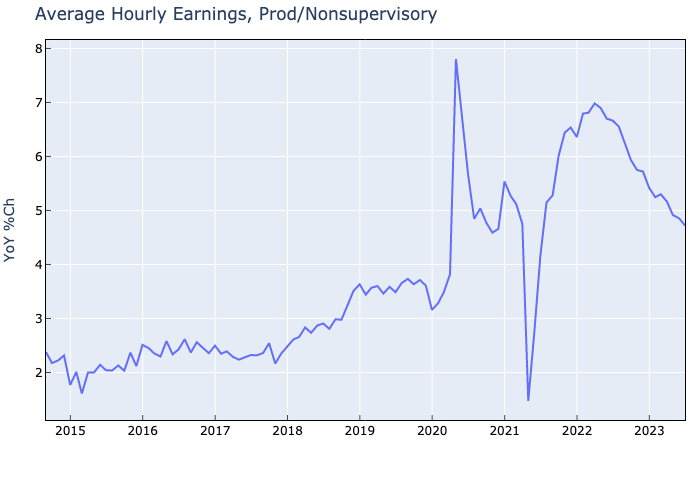

In [119]:
chartbook_panel('AHETPI')

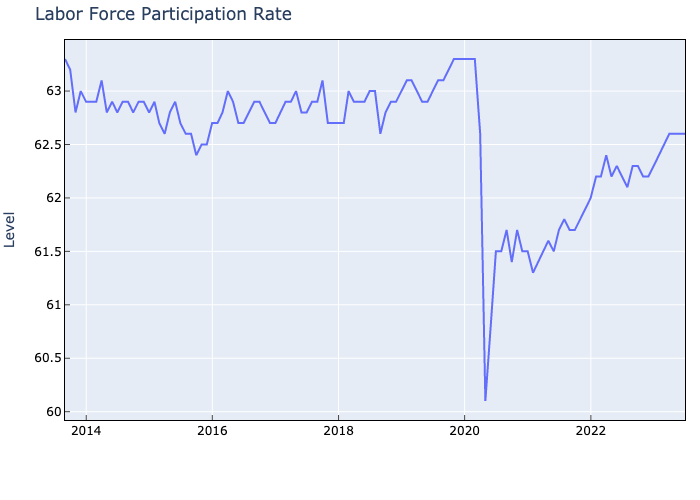

In [50]:
chartbook_panel('CIVPART')


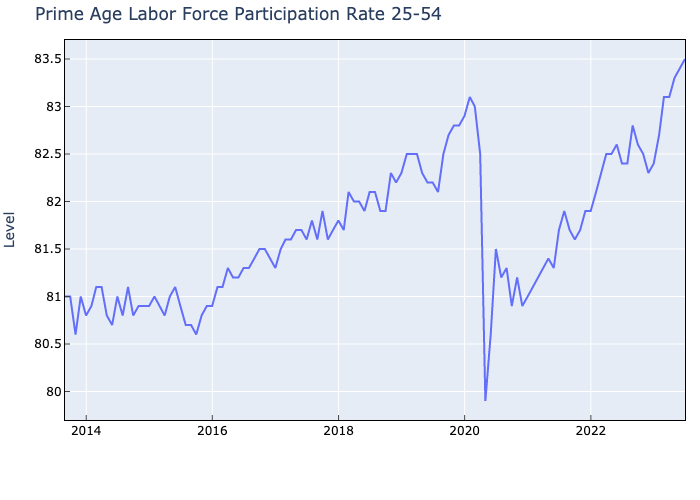

In [51]:
chartbook_panel('LNS11300060')


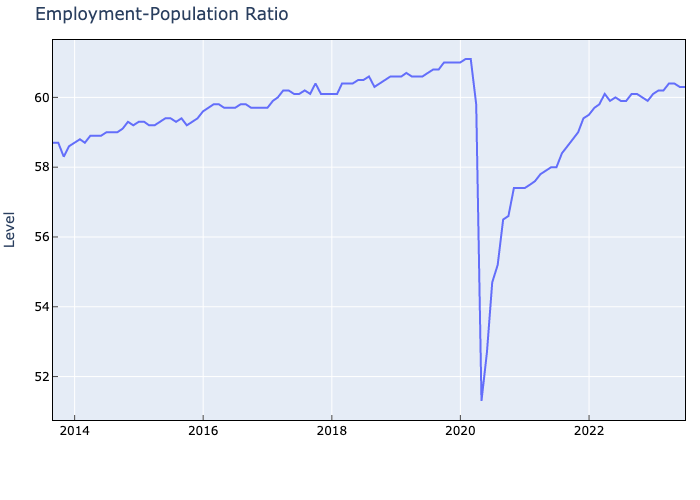

In [52]:
chartbook_panel('EMRATIO')


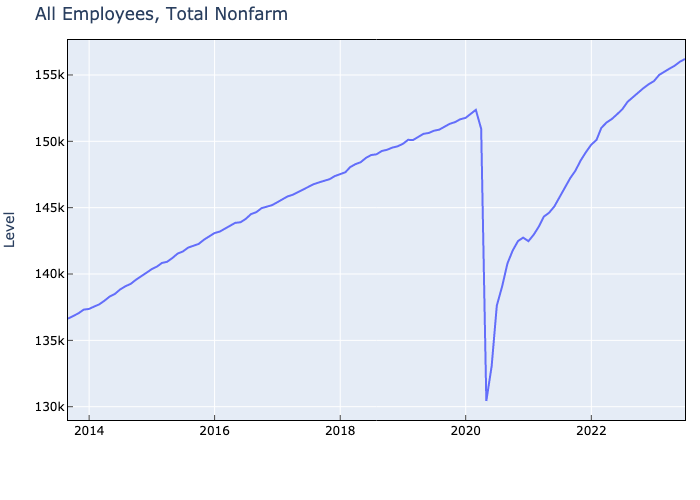

In [53]:
chartbook_panel('PAYEMS')


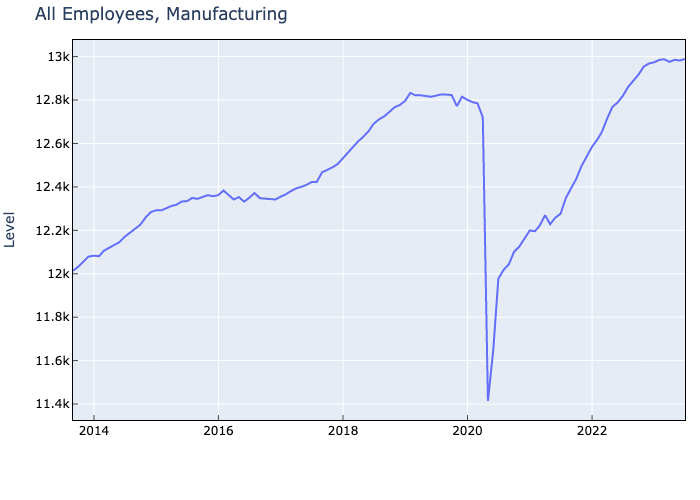

In [54]:
chartbook_panel('MANEMP')


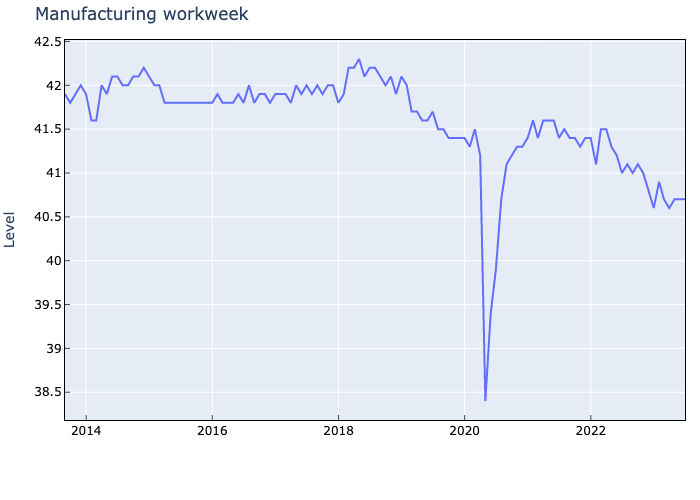

In [55]:
chartbook_panel('AWHMAN')


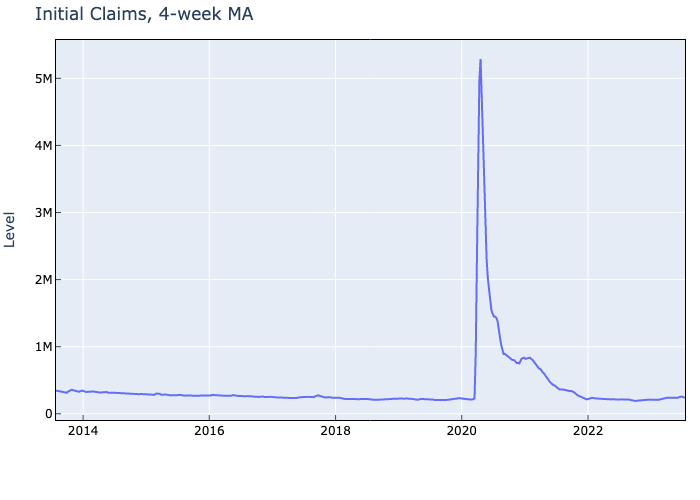

In [56]:
chartbook_panel('IC4WSA')


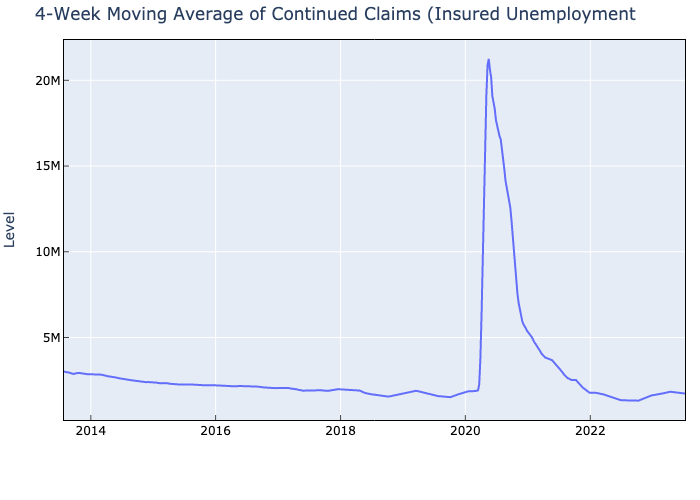

In [57]:
chartbook_panel('CC4WSA')


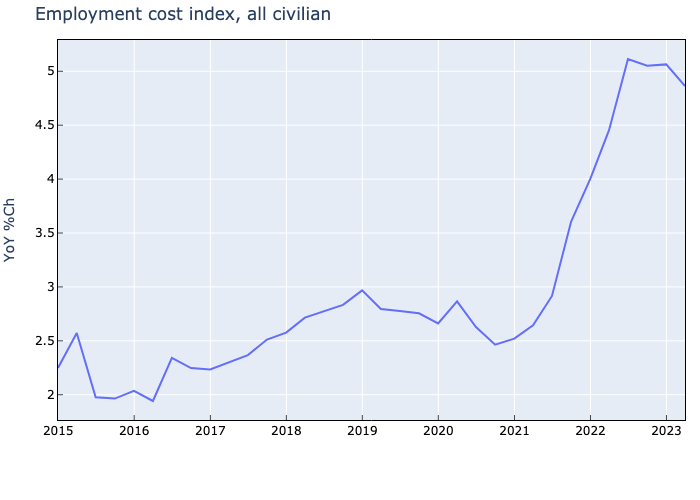

In [58]:
chartbook_panel('ECIALLCIV')


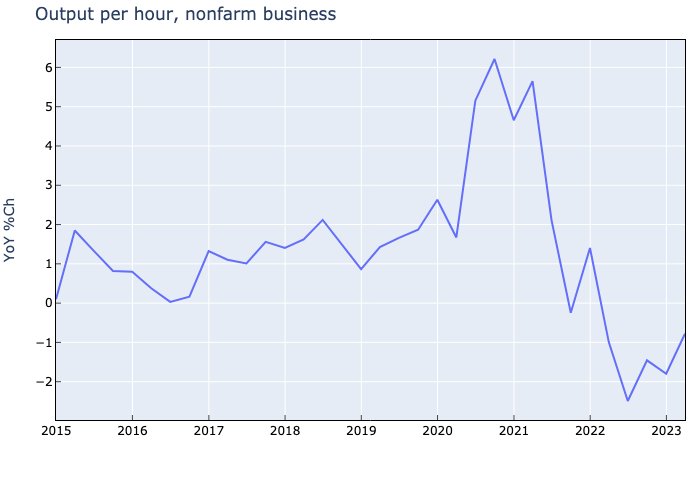

In [59]:
chartbook_panel('OPHNFB')


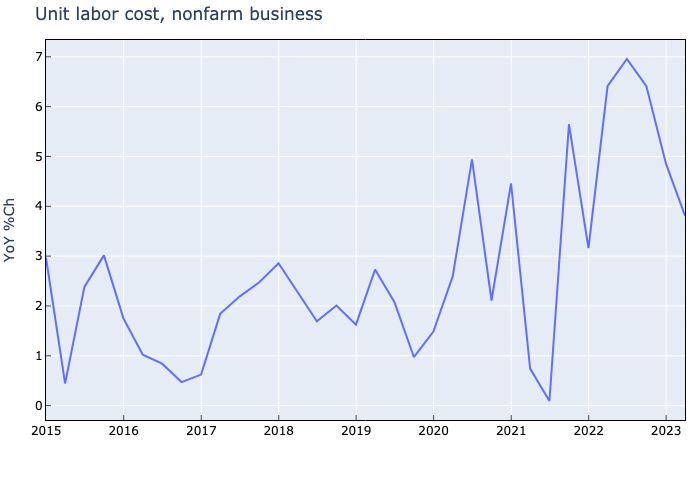

In [60]:
chartbook_panel('ULCNFB')


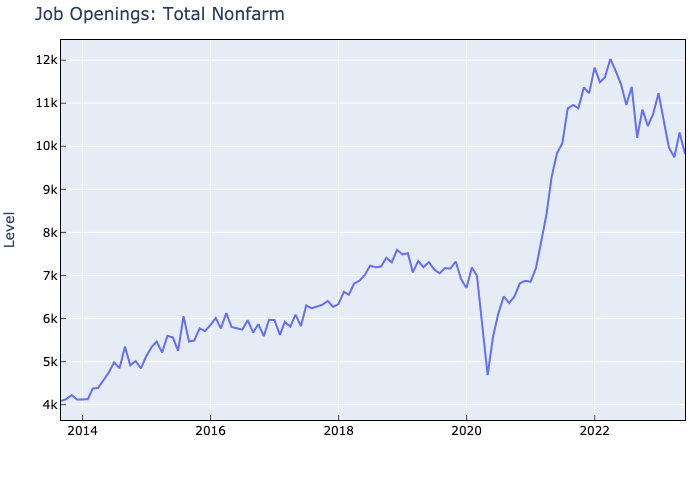

In [61]:
chartbook_panel('JTSJOL')


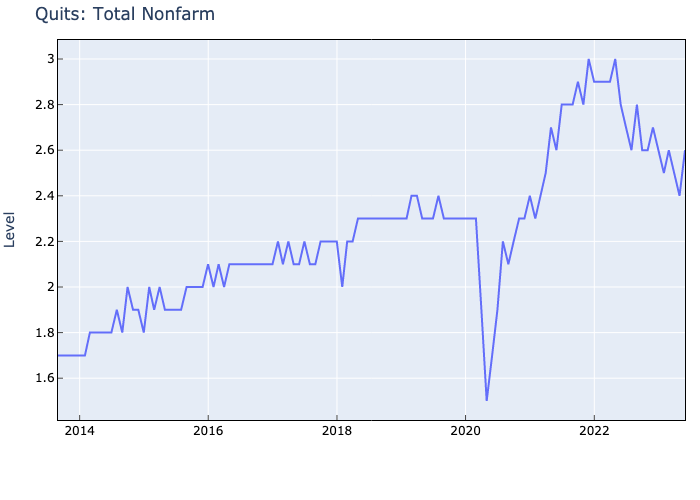

In [62]:
chartbook_panel('JTSQUR')


# Personal Income and Consumption

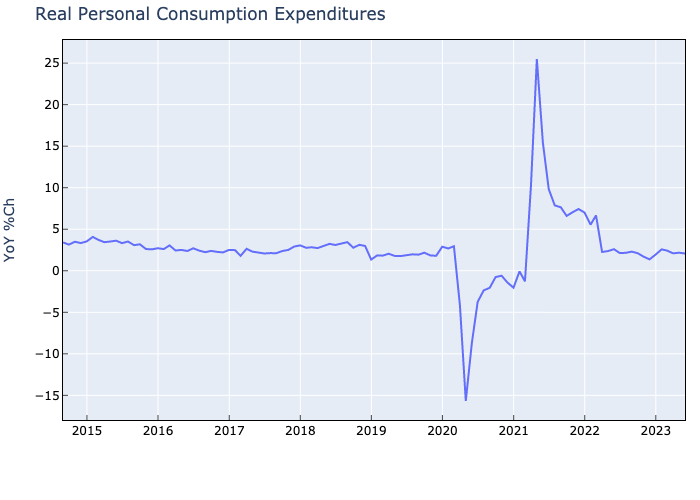

In [63]:
chartbook_panel('PCEC96')


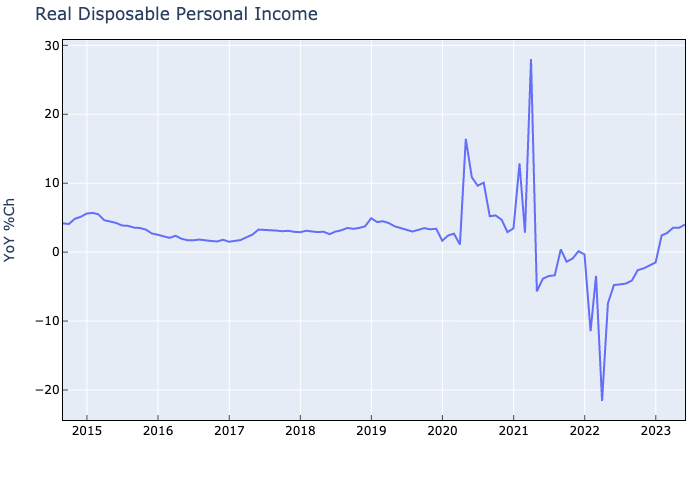

In [64]:
chartbook_panel('DSPIC96')


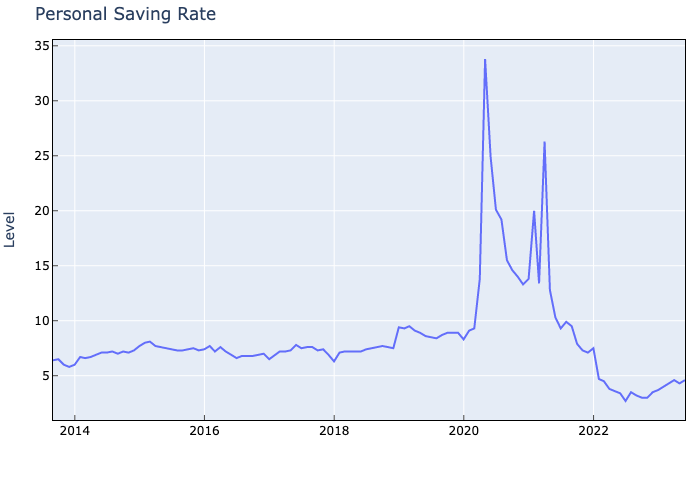

In [65]:
chartbook_panel('PSAVERT')


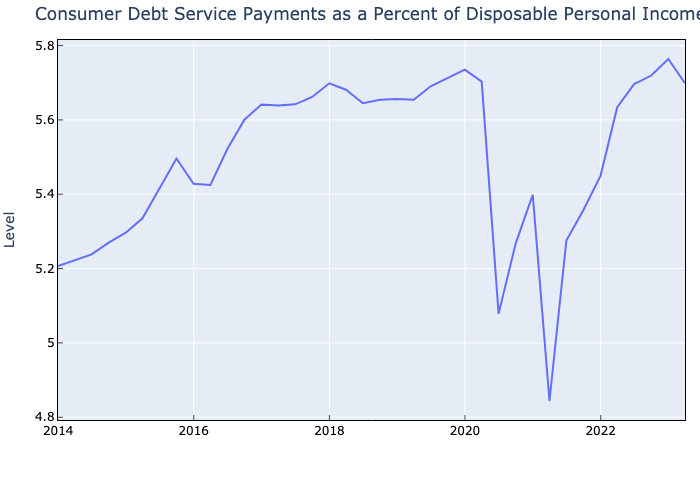

In [66]:
chartbook_panel('CDSP')


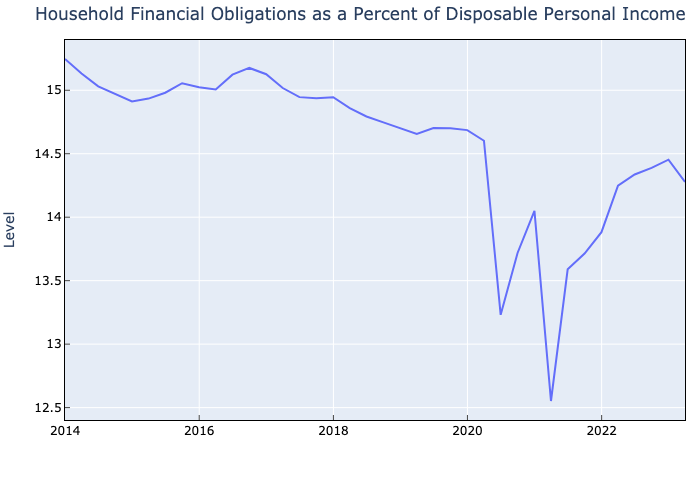

In [67]:
chartbook_panel('FODSP')


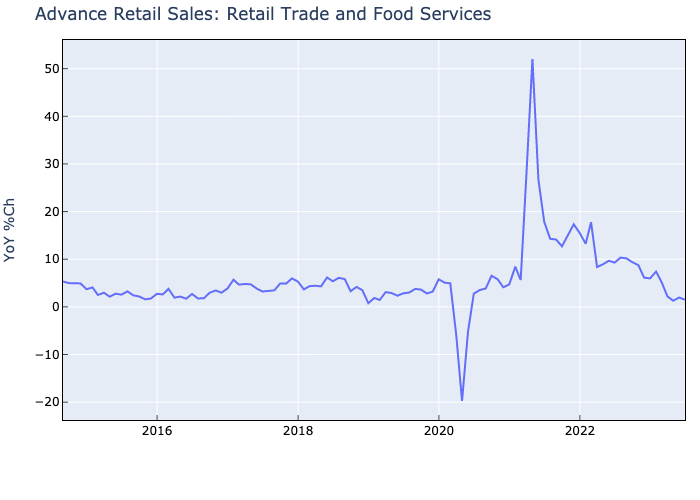

In [68]:
chartbook_panel('RSAFS')


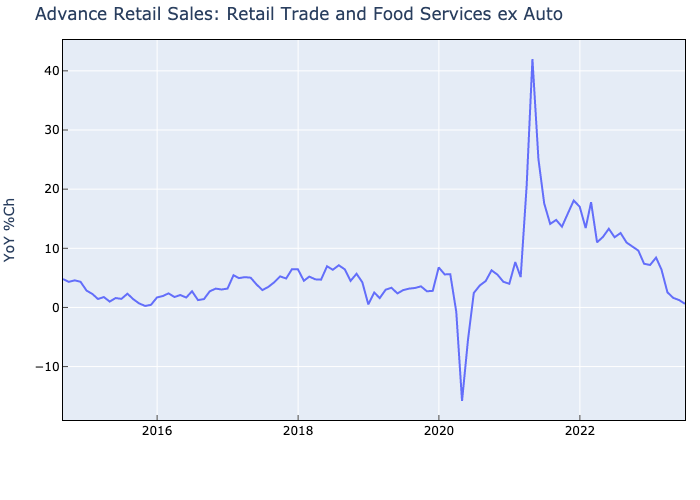

In [69]:
chartbook_panel('RSFSXMV')


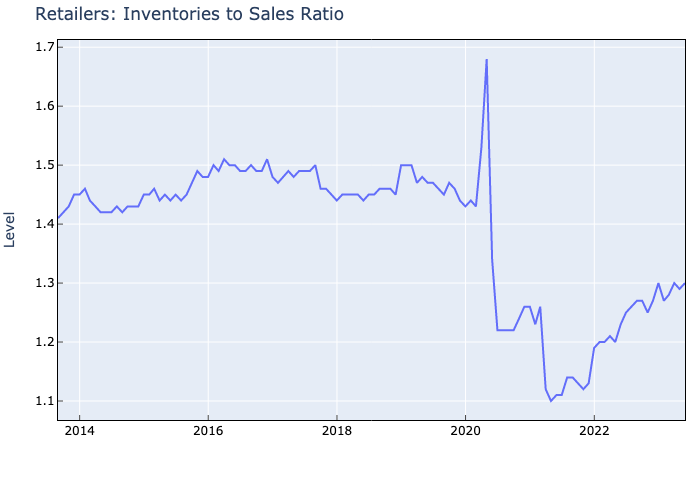

In [70]:
chartbook_panel('RETAILIRSA')


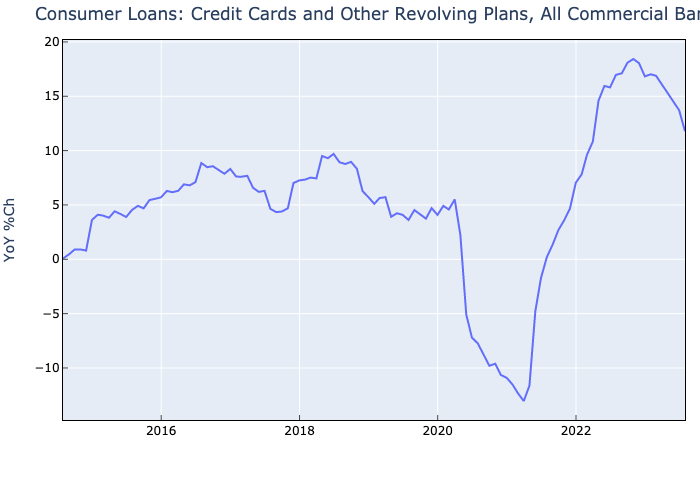

In [71]:
chartbook_panel('CCLACBW027SBOG')


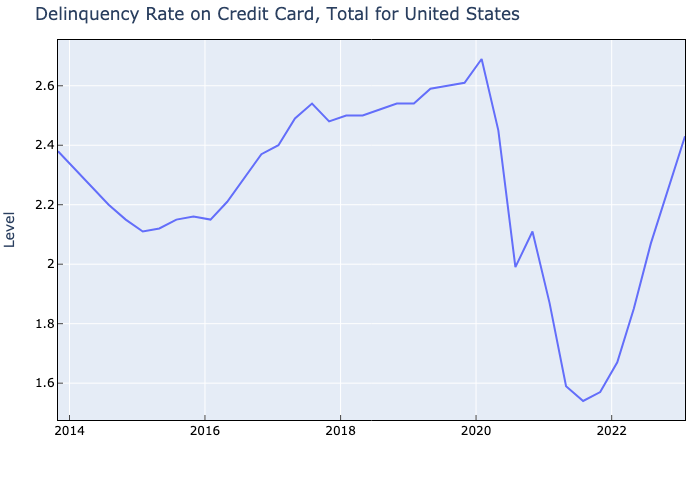

In [72]:
chartbook_panel('DRCCLACBS')

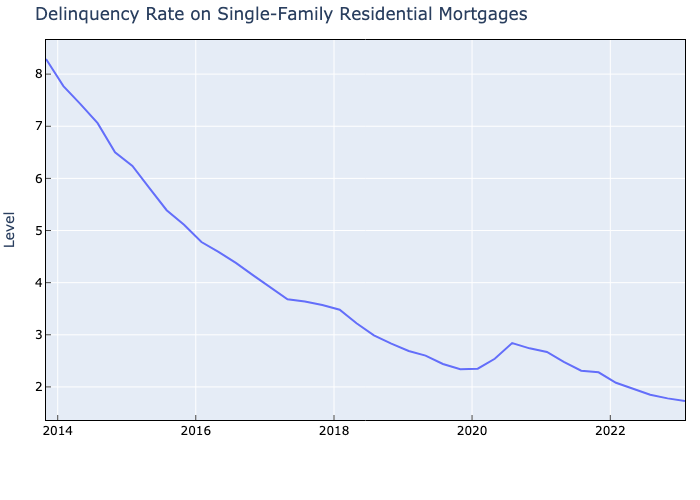

In [73]:
chartbook_panel('DRSFRMACBS')

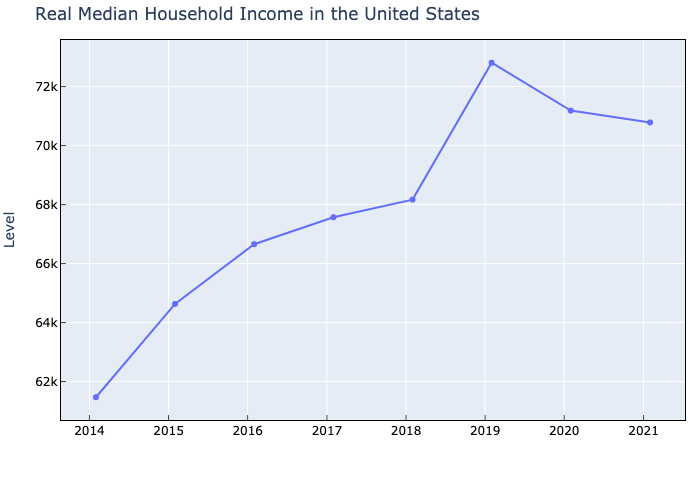

In [74]:
chartbook_panel('MEHOINUSA672N')

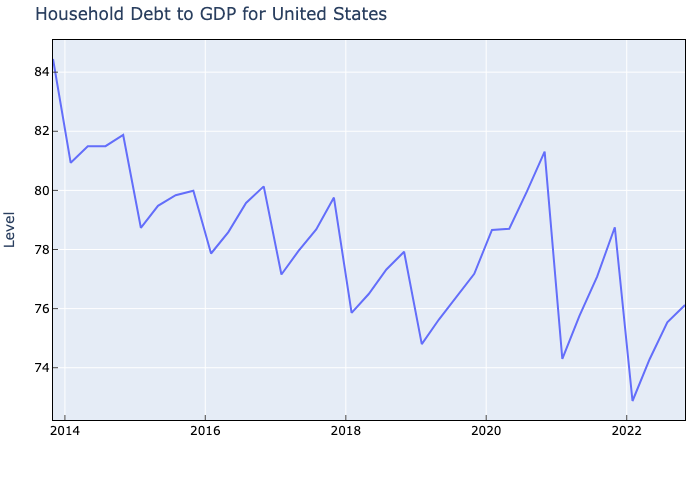

In [75]:
chartbook_panel('HDTGPDUSQ163N')

# Housing

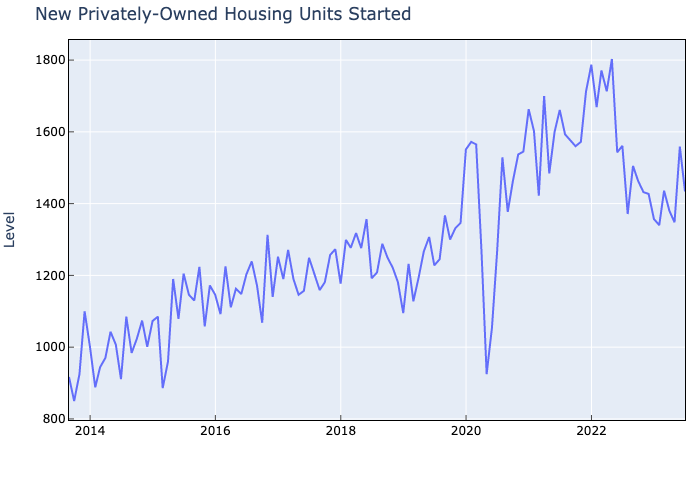

In [76]:
chartbook_panel('HOUST')

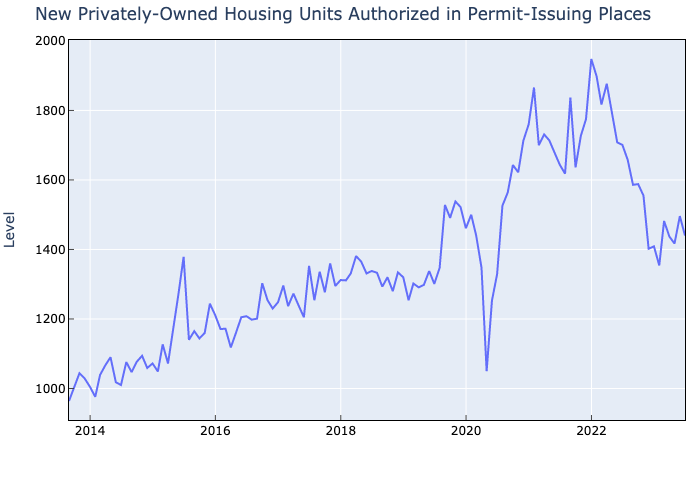

In [77]:
chartbook_panel('PERMIT')

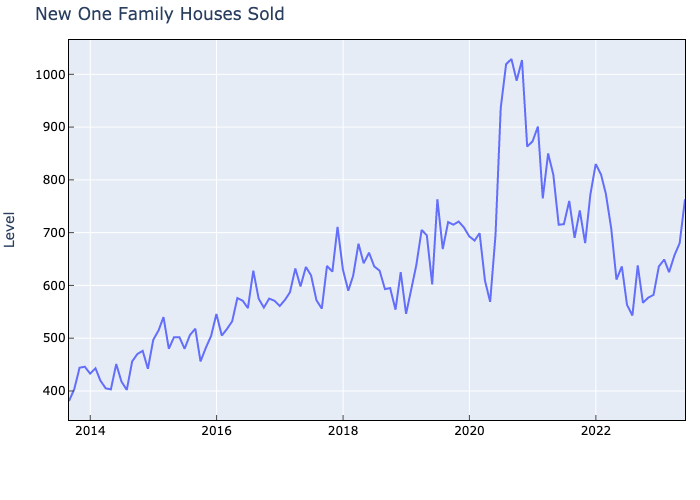

In [78]:
chartbook_panel('HSN1F')

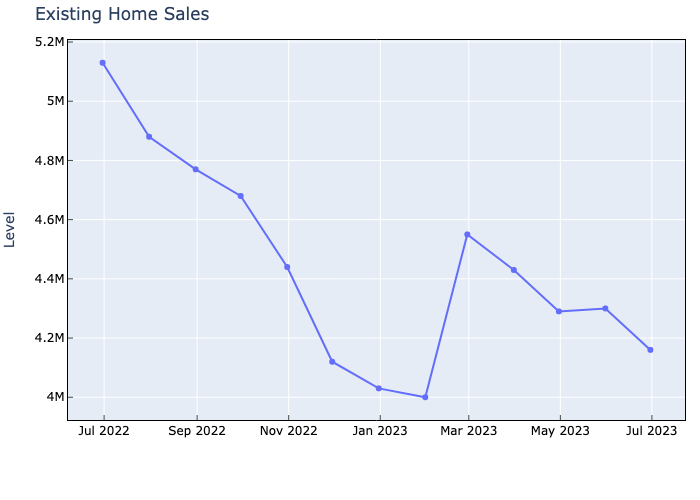

In [79]:
chartbook_panel('EXHOSLUSM495S')

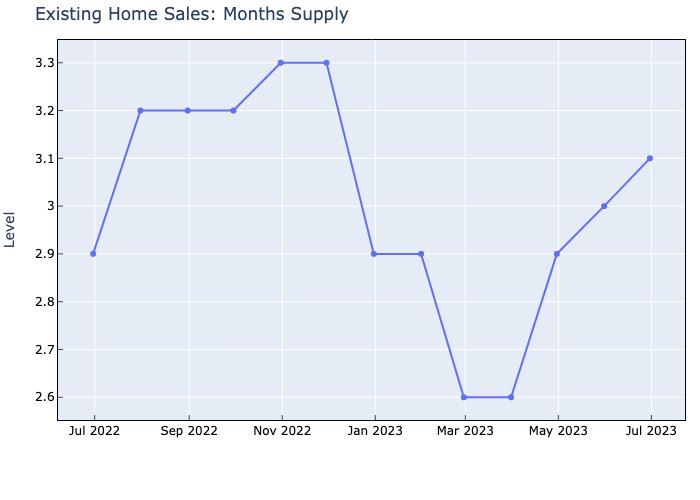

In [80]:
chartbook_panel('HOSSUPUSM673N')

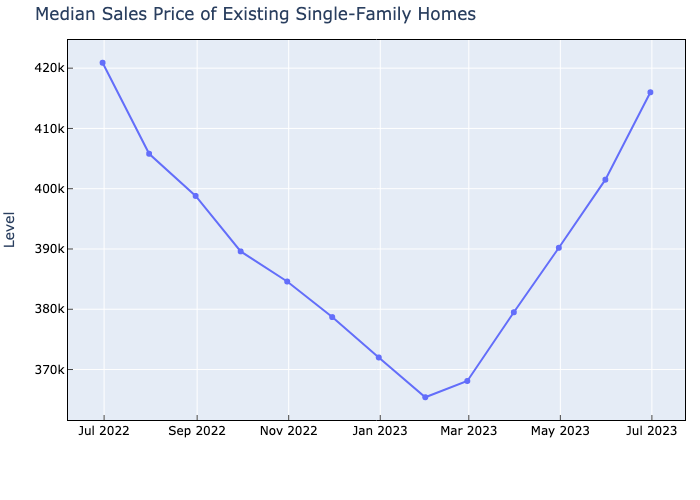

In [81]:
chartbook_panel('HSFMEDUSM052N')

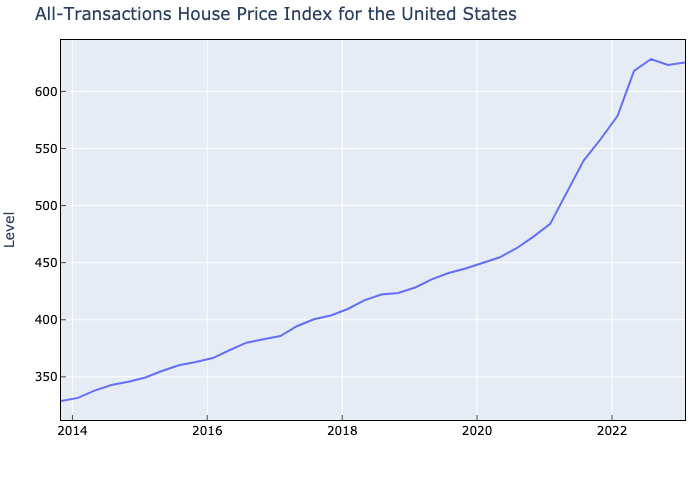

In [82]:
chartbook_panel('USSTHPI')

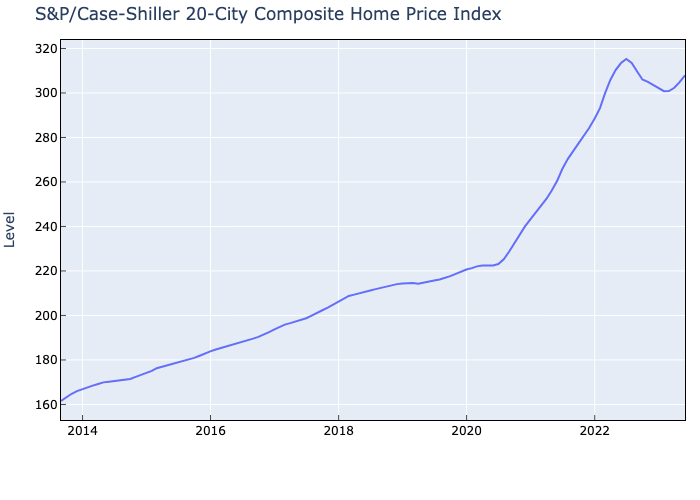

In [83]:
chartbook_panel('SPCS20RSA')

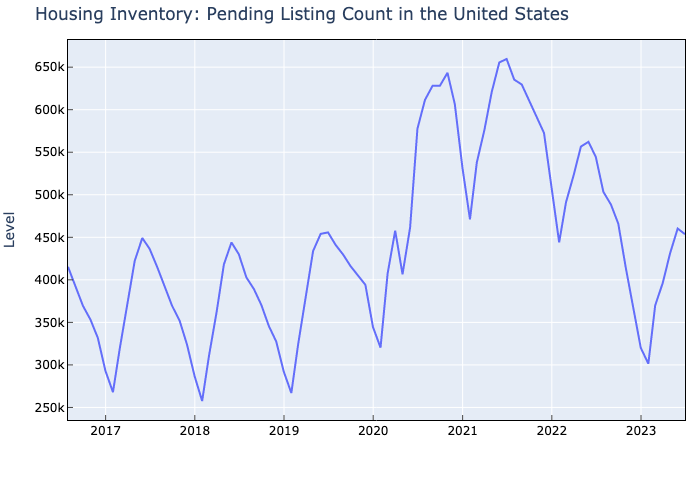

In [84]:
chartbook_panel('PENLISCOUUS')

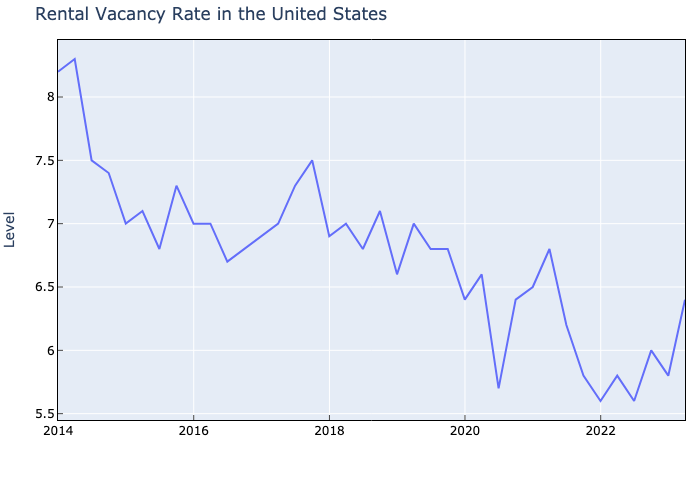

In [85]:
chartbook_panel('RRVRUSQ156N')

# Manufacturing

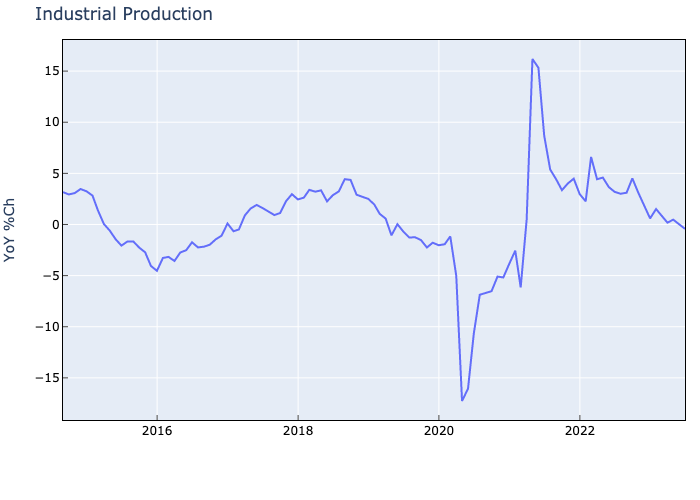

In [86]:
chartbook_panel('INDPRO')

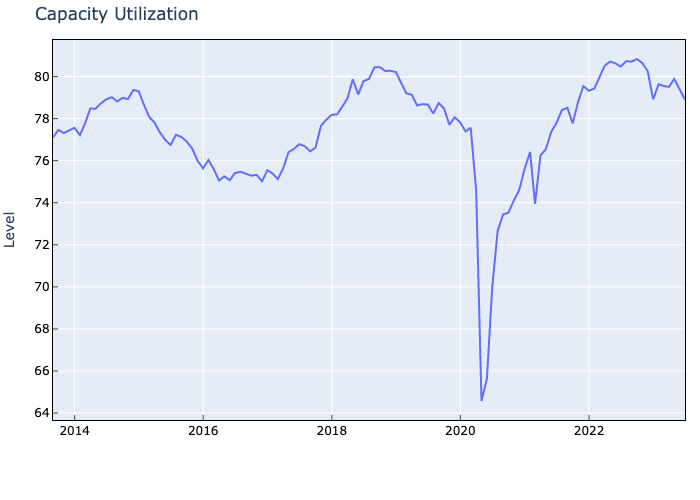

In [87]:
chartbook_panel('TCU')

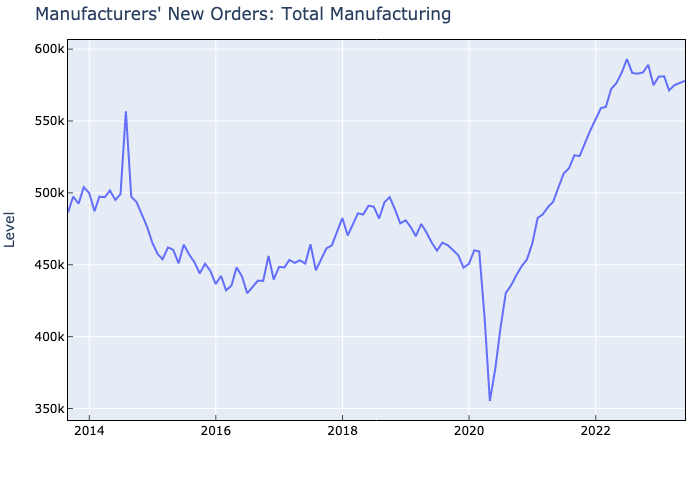

In [88]:
chartbook_panel('AMTMNO')

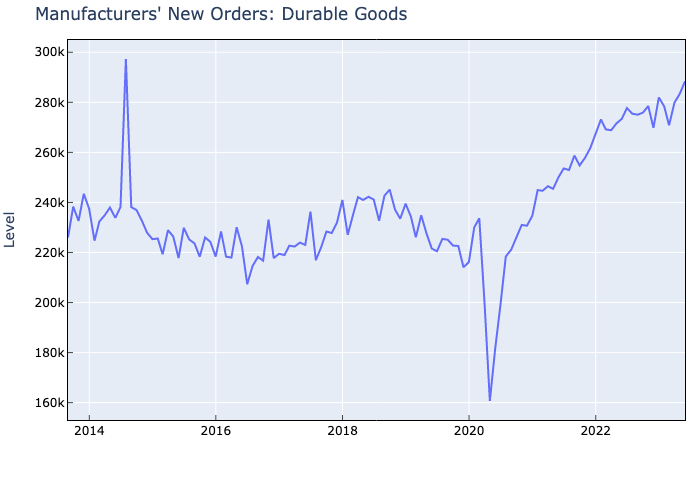

In [89]:
chartbook_panel('DGORDER')

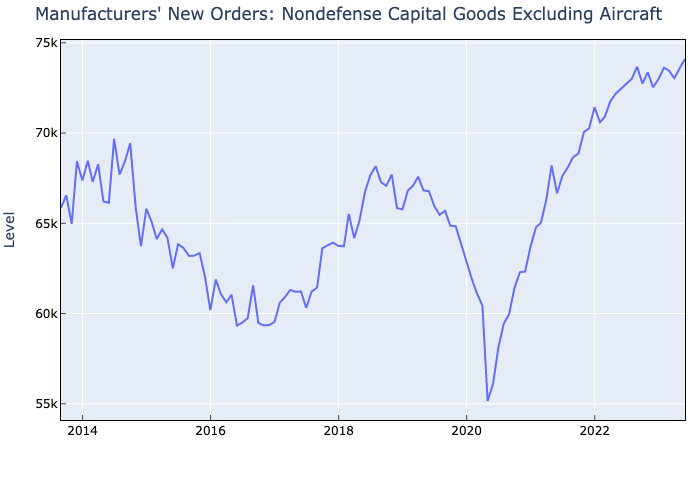

In [90]:
chartbook_panel('NEWORDER')

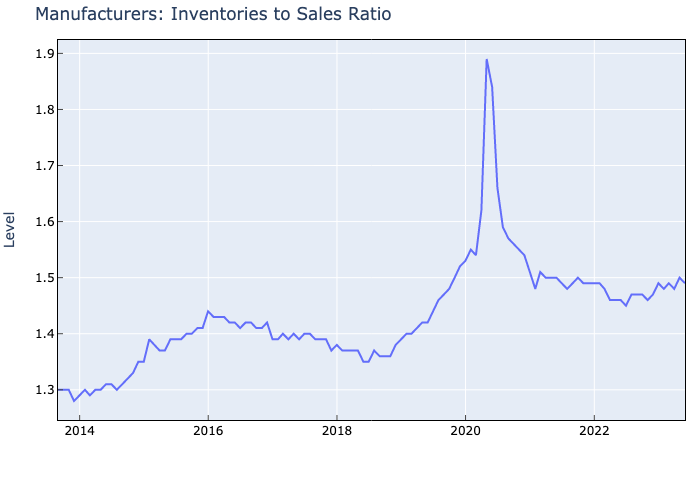

In [91]:
chartbook_panel('MNFCTRIRSA')

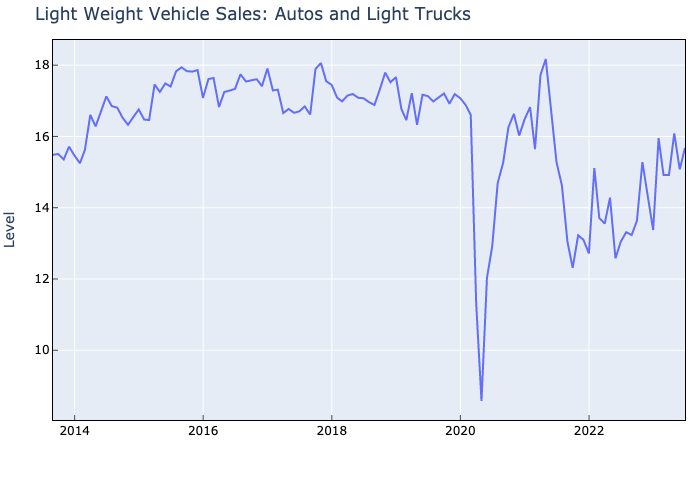

In [92]:
chartbook_panel('ALTSALES')

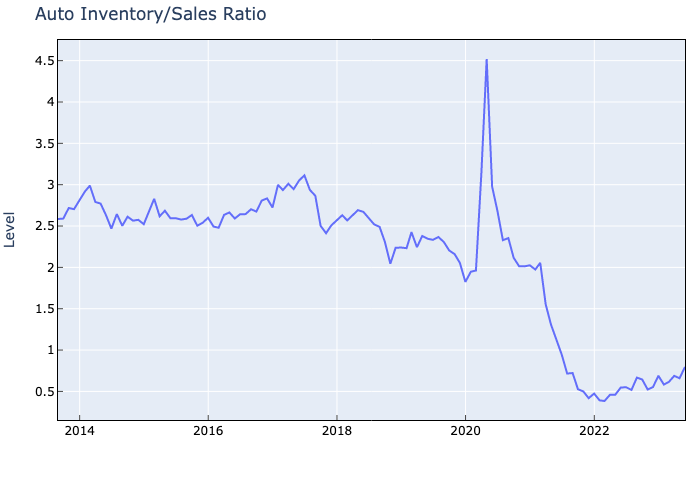

In [93]:
chartbook_panel('AISRSA')

# Government


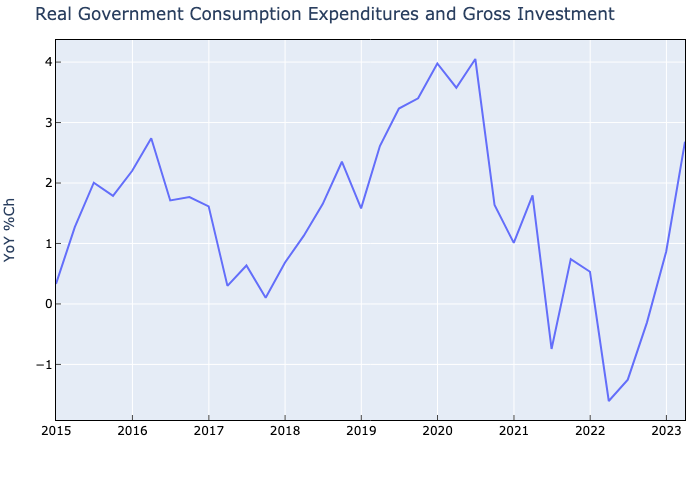

In [94]:
chartbook_panel('GCEC1')

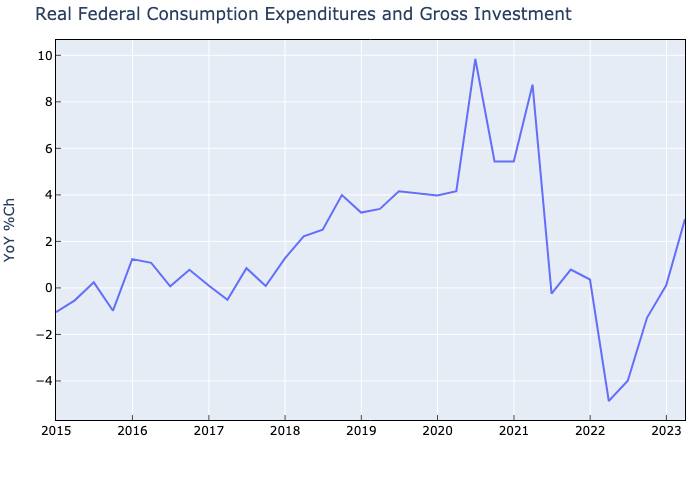

In [95]:
chartbook_panel('FGCEC1')

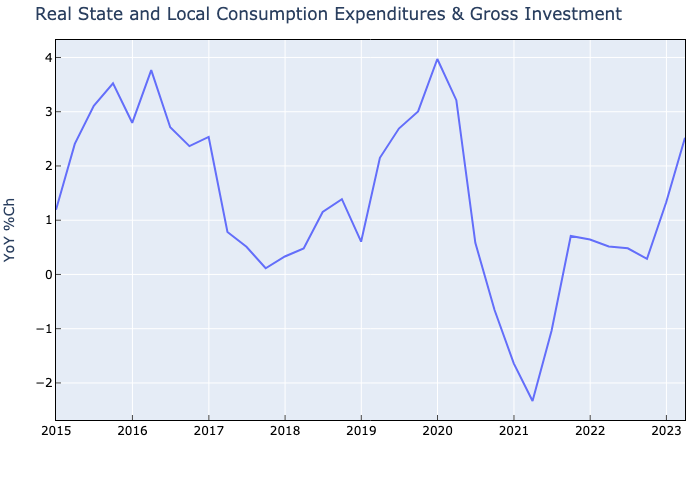

In [96]:
chartbook_panel('SLCEC1')


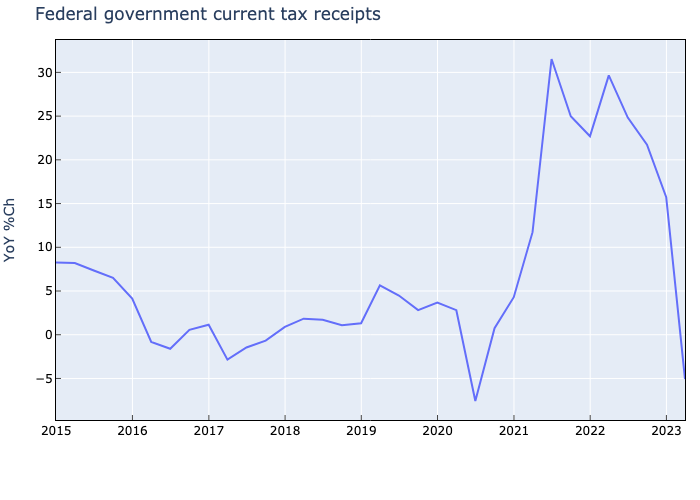

In [97]:
chartbook_panel('W006RC1Q027SBEA')

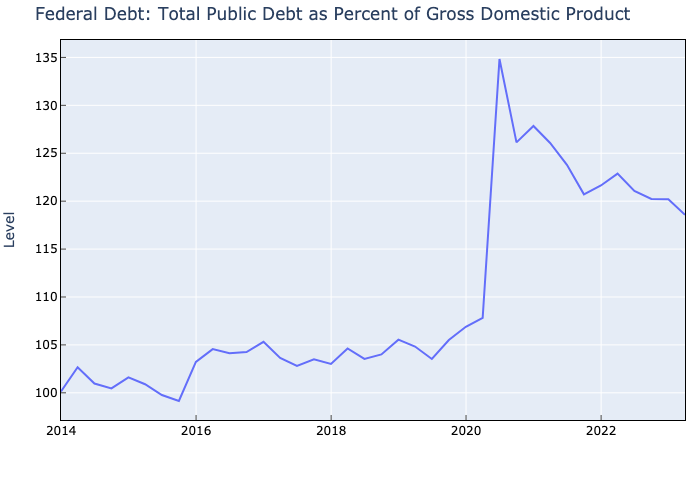

In [98]:
chartbook_panel('GFDEGDQ188S')

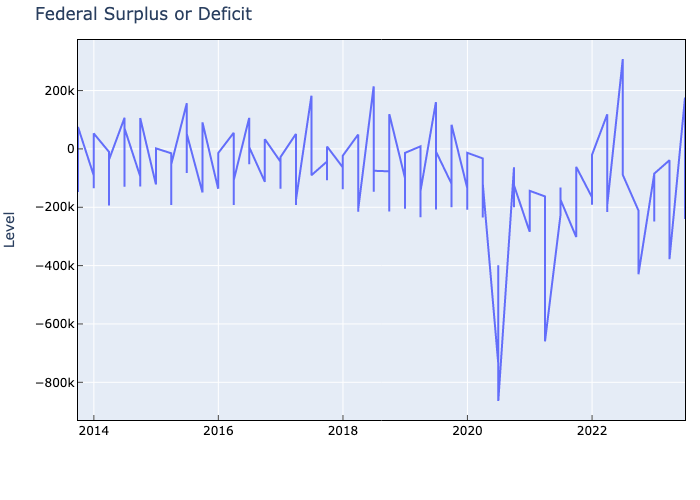

In [99]:
chartbook_panel('MTSDS133FMS')

# External


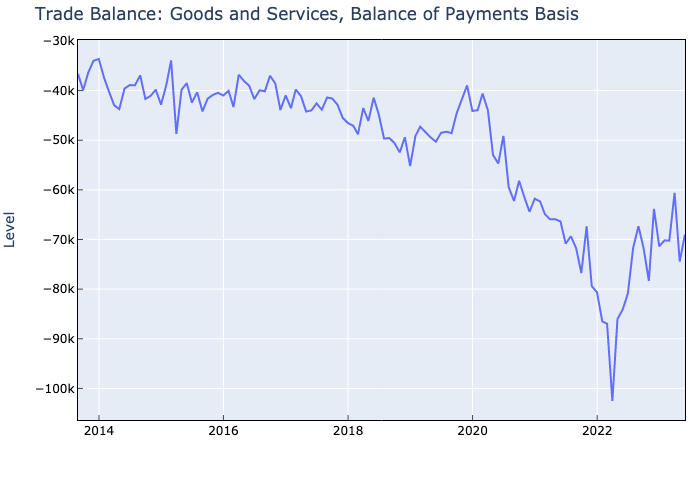

In [100]:
chartbook_panel('BOPGSTB')

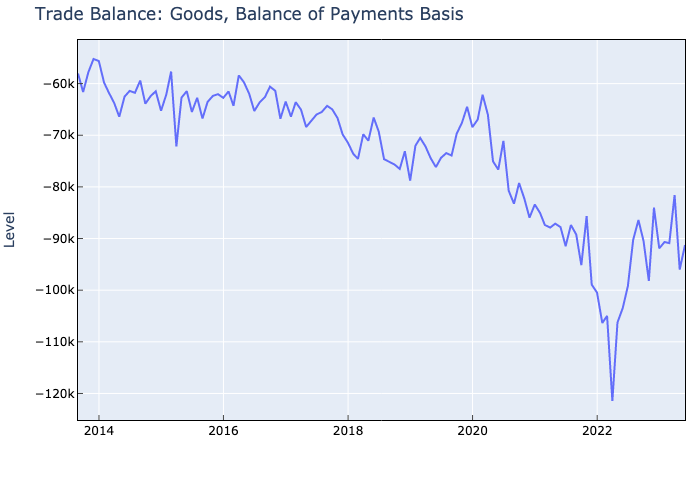

In [101]:
chartbook_panel('BOPGTB')

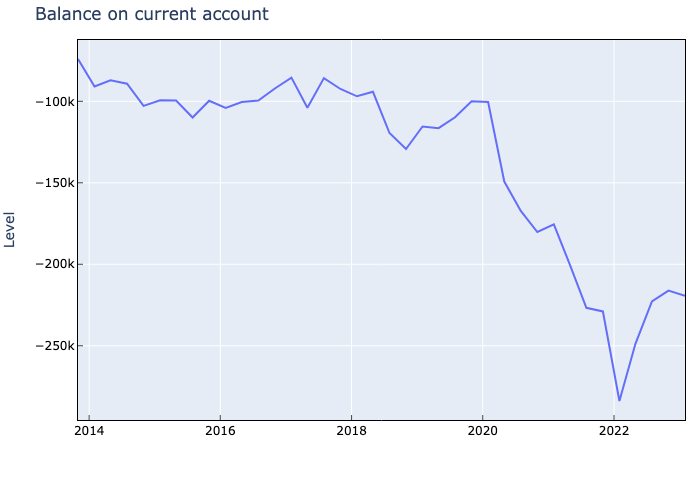

In [102]:
chartbook_panel('IEABC')

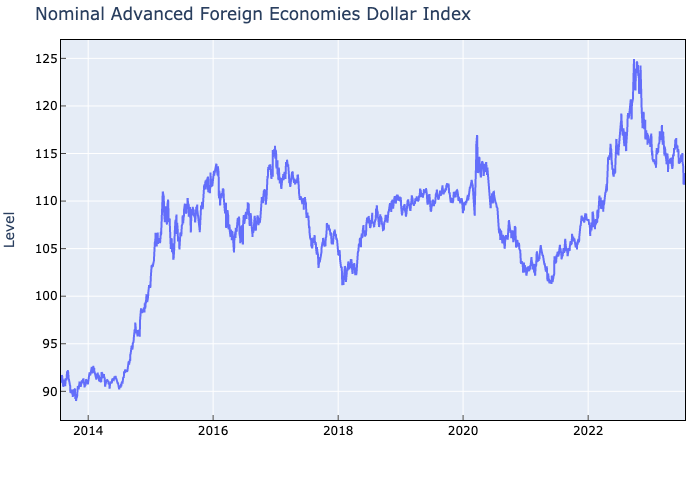

In [103]:
chartbook_panel('DTWEXAFEGS')

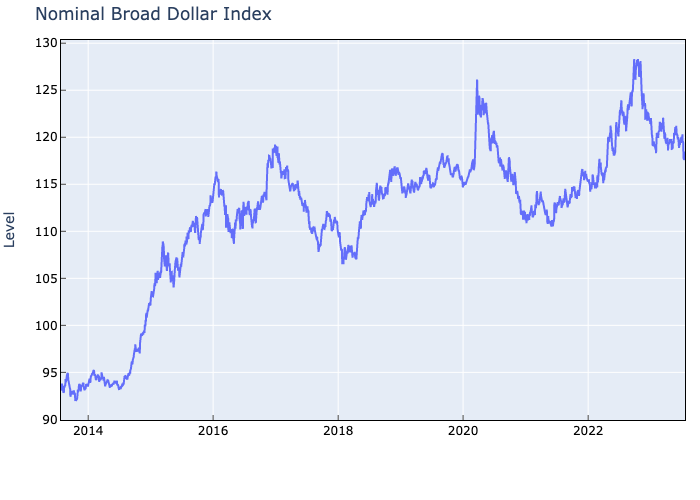

In [104]:
chartbook_panel('DTWEXBGS')

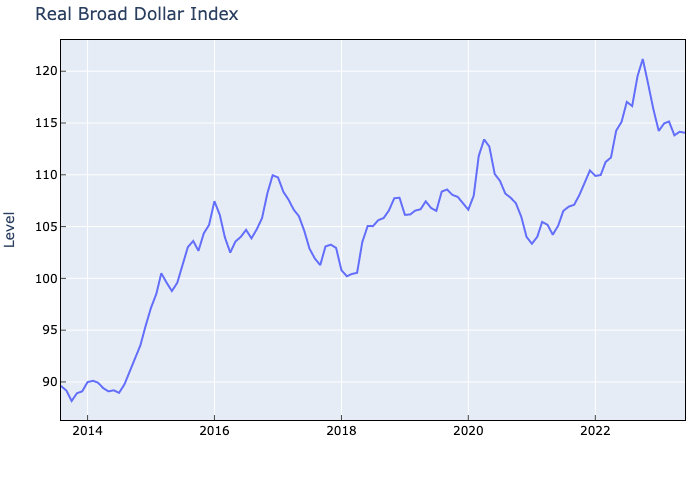

In [105]:
chartbook_panel('RTWEXBGS')

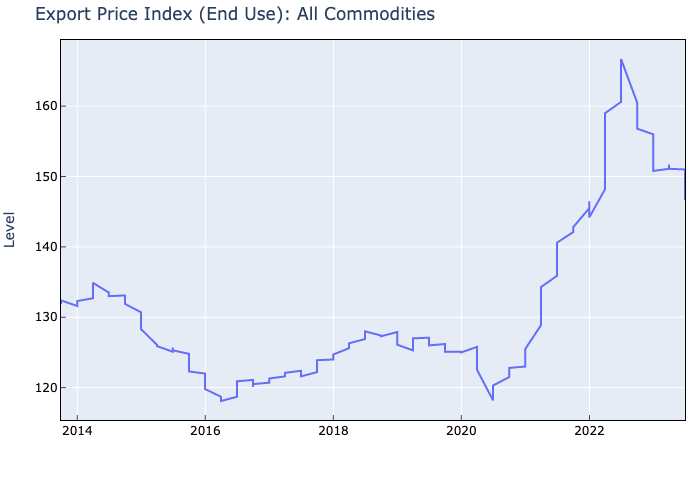

In [106]:
chartbook_panel('IQ')

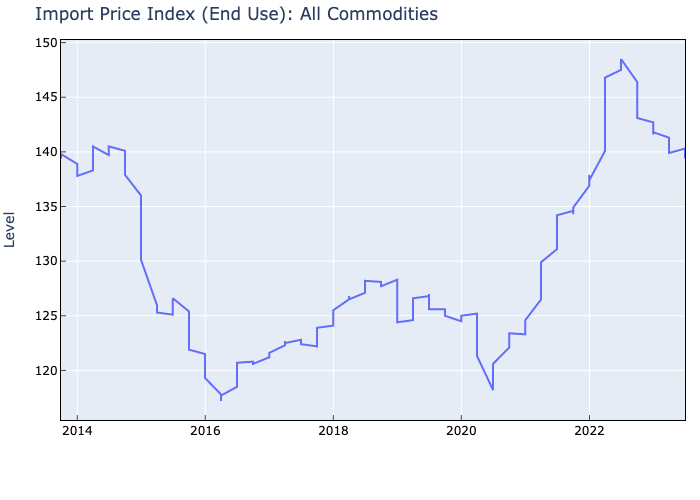

In [107]:
chartbook_panel('IR')

# Surveys

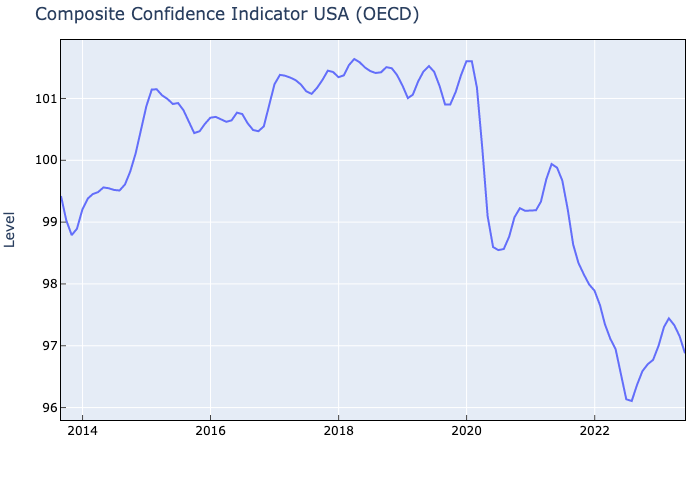

In [108]:
chartbook_panel('CSCICP03USM665S')

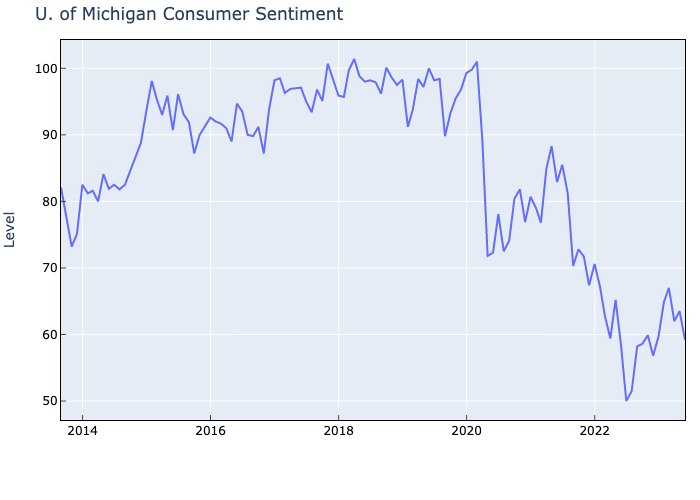

In [109]:
chartbook_panel('UMCSENT')

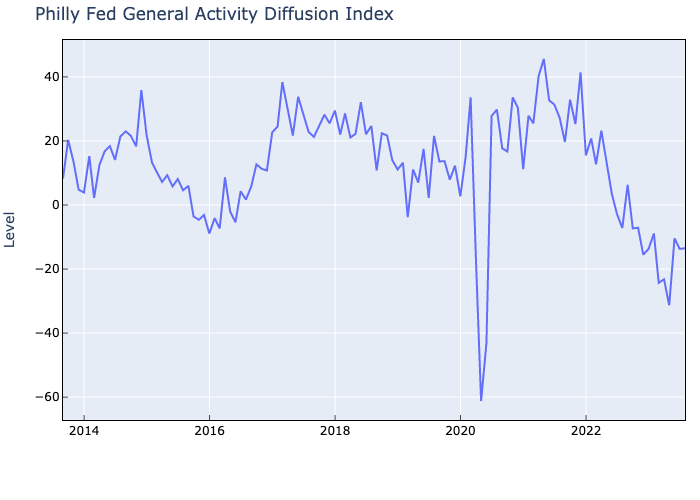

In [110]:
chartbook_panel('GACDFSA066MSFRBPHI')

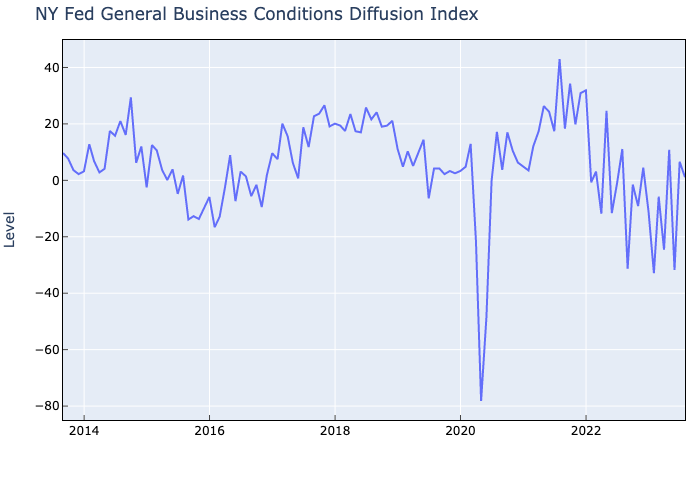

In [111]:
chartbook_panel('GACDISA066MSFRBNY')

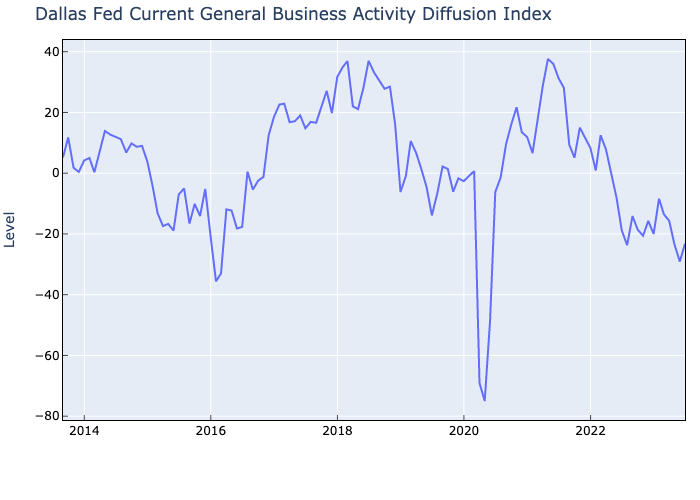

In [112]:
chartbook_panel('BACTSAMFRBDAL')

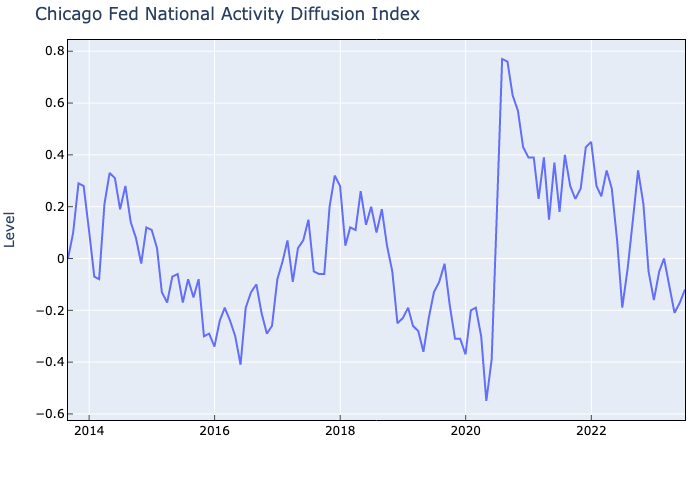

In [113]:
chartbook_panel('CFNAIDIFF')

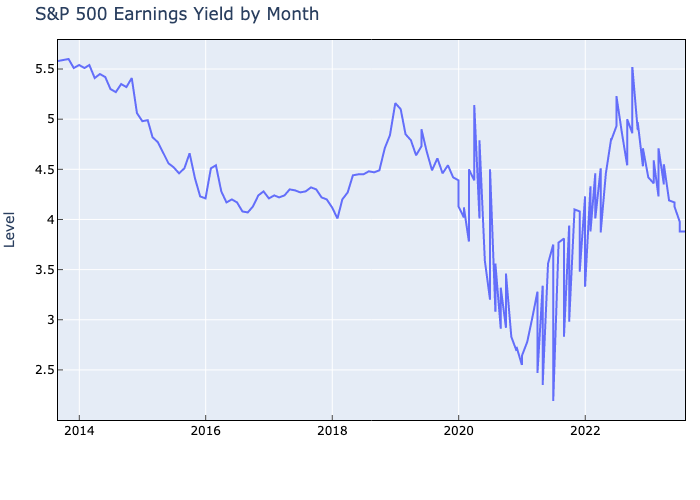

In [114]:
chartbook_panel('MULTPL_SP500_EARNINGS_YIELD_MONTH')

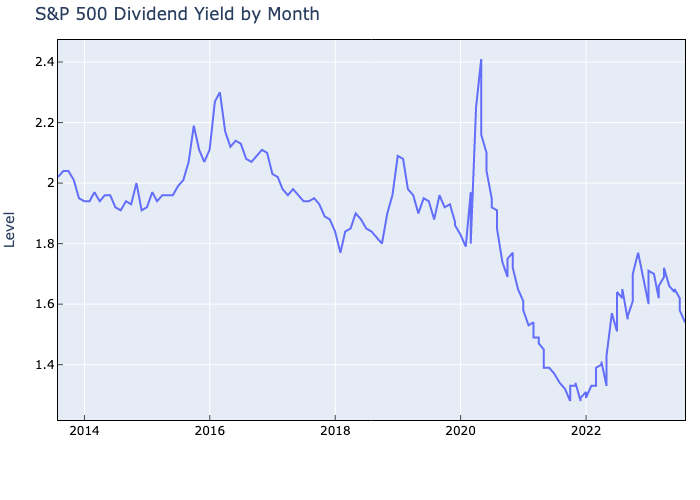

In [115]:
chartbook_panel('MULTPL_SP500_DIV_YIELD_MONTH')

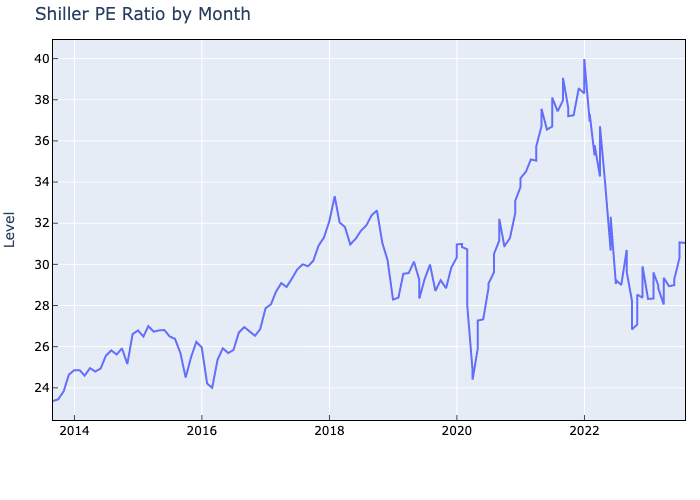

In [116]:
chartbook_panel('MULTPL_SHILLER_PE_RATIO_MONTH')

In [117]:
# df = pd.DataFrame({'cost':    [0.227,  0.332, 0.37, 0.5, 0.6, 0.83],
#                    'benefit': [0.515, 0.55, 0.625, 0.7, 0.8, 0.9]})
# labels = ["1. Policies, Controls, Monitoring",
#           "2. Best Practices, Documentation and Training",
#           "3. Simple Workflow Automation",
#           "4. Question Answering Over Internal Data",
#           "5. Complex Workflow Automation & Agents",
#           "6. Custom LLM models"
#          ]

# df

In [118]:
# fig = go.Figure(
#     data=[go.Scatter(x=df['cost'].to_list(),
#                      y=df['benefit'].to_list(),
#                      line_width=2,
#                      mode='text',
#                      textposition='top center',
#                      text=labels,
#                      textfont=dict(
#                          family="Arial",
#                          size=18, 
#                          color="Black"
#                      )
#                     ),
#          ],
#     layout=dict(
#     autosize=True,
#             width=640,
#             height=640,            
#             margin={'l': 10, 'r': 15, 't': 40},
#             paper_bgcolor="white",
#             #plot_bgcolor="white",
#             showlegend=False,
#             legend=dict(
#                 orientation="h",
#                 yanchor="bottom",
#                 y=1.02,
#                 xanchor="left",
#                 x=0
#             ),
#             xaxis={
#                 'range': [0, 1],                
#                 'ticks': 'inside',
#                 'tick0': 0.0, 
#                 'dtick': 0.5,                
#                 'showgrid': True,            # thin lines in the background
#                 'zeroline': False,           # thick line at x=0
#                 'visible': True,             # numbers below
#                 'showline': True,            # Show X-Axis
#                 'linecolor': 'black',        # Color of X-axis
#                 'tickfont_color': 'black',   # Color of ticks
#                 'tickfont_size' : 16,                
#                 'showticklabels': True,      # Show X labels
#                 'mirror': True,              # draw right axis
#             },
#             yaxis={
#                 'range': [0, 1],
#                 'ticks': 'inside',
#                 'tick0': 0.0, 
#                 'dtick': 0.5,                
#                 'showgrid': True,            # thin lines in the background
#                 'zeroline': False,           # thick line at x=0
#                 'visible': True,             # numbers below
#                 'showline': True,            # Show X-Axis
#                 'linecolor': 'black',        # Color of X-axis
#                 'tickfont_color': 'black',   # Color of ticks
#                 'tickfont_size' : 16,
#                 'showticklabels': True,      # Show X labels
#                 'side': 'left',
#                 'mirror': True,
#             },
#         )    
# )

# fig.update_layout(dict(title='Quadrant Chart / 2 x 2 matrix',
#                        yaxis={'title': 'Benefit or Reward',
#                              'titlefont': {'size': 18}},
#                        xaxis={'title':'Cost or Risk',
#                               'titlefont': {'size': 18}},
#                       ))

# # ?    yaxis = list(titlefont = list(size = 25), title = "test"))

